# Latent components

Latent components are model components which only activate in conjunction with other components. They can only be detected by identifying differences in attribution scores between activation patching from clean to corrupt, and activation patching from corrupt to clean.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance, run_latent_ablation_experiment
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Loaded pretrained model gpt2-small into HookedTransformer


## Approximating activation patching

Hypothesis: integrated gradients can approximate activation patching in either direction.

To evaluate this hypothesis, we use 100 samples from the IOI dataset and run:

- Activation patching from clean to corrupt
- Activation patching from corrupt to clean
- Integrated gradients with corrupt input and clean baseline
- Integrated gradients with clean input and corrupt baseline

We then compare the resulting attribution scores from the four runs.

### Experiment

In [4]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [ ]:
ig_clean_corrupt_mlp, ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ig_clean_corrupt_mlp, "results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
torch.save(ig_clean_corrupt_attn, "results/latent_components/ioi/ig_clean_corrupt_attn.pt")

In [ ]:
ap_clean_corrupt_mlp, ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ap_clean_corrupt_mlp, "results/latent_components/ioi/ap_clean_corrupt_mlp.pt")
torch.save(ap_clean_corrupt_attn, "results/latent_components/ioi/ap_clean_corrupt_attn.pt")

In [ ]:
ig_corrupt_clean_mlp, ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(ig_corrupt_clean_mlp, "results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
torch.save(ig_corrupt_clean_attn, "results/latent_components/ioi/ig_corrupt_clean_attn.pt")

In [ ]:
ap_corrupt_clean_mlp, ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_cache, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(ap_corrupt_clean_mlp, "results/latent_components/ioi/ap_corrupt_clean_mlp.pt")
torch.save(ap_corrupt_clean_attn, "results/latent_components/ioi/ap_corrupt_clean_attn.pt")

### Analysis

We first visualise ten results from each of the four runs. We then calculate the average correlation coefficient across all 100 samples.

In [5]:
ig_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("results/latent_components/ioi/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("results/latent_components/ioi/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("results/latent_components/ioi/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")

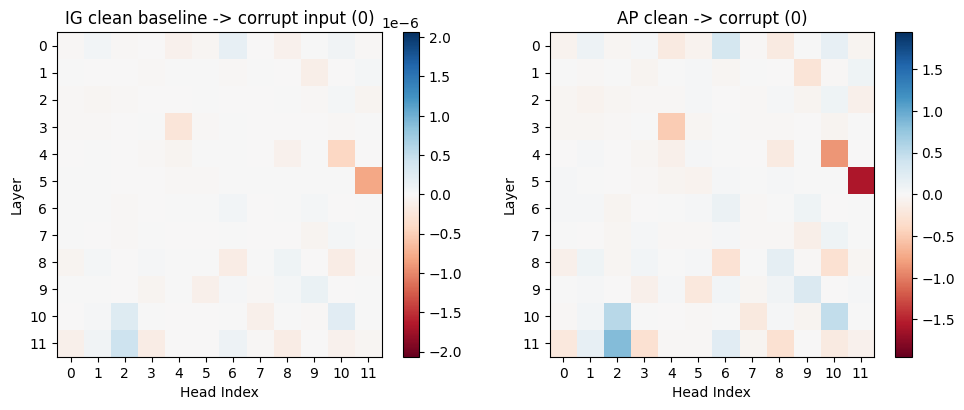

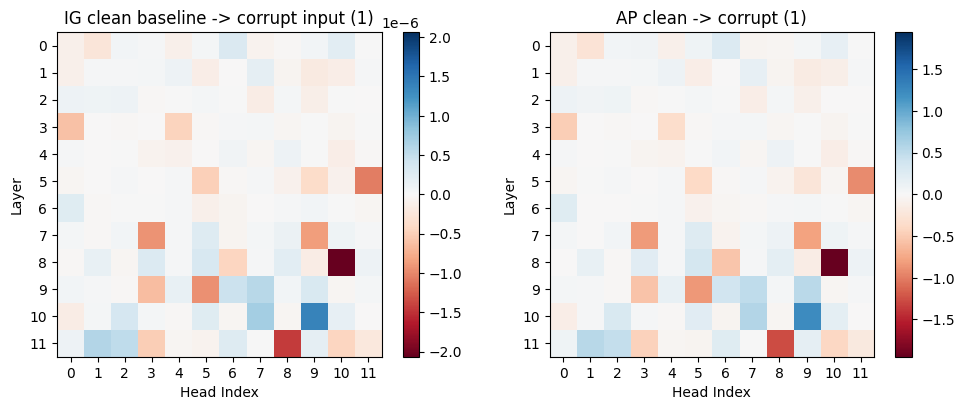

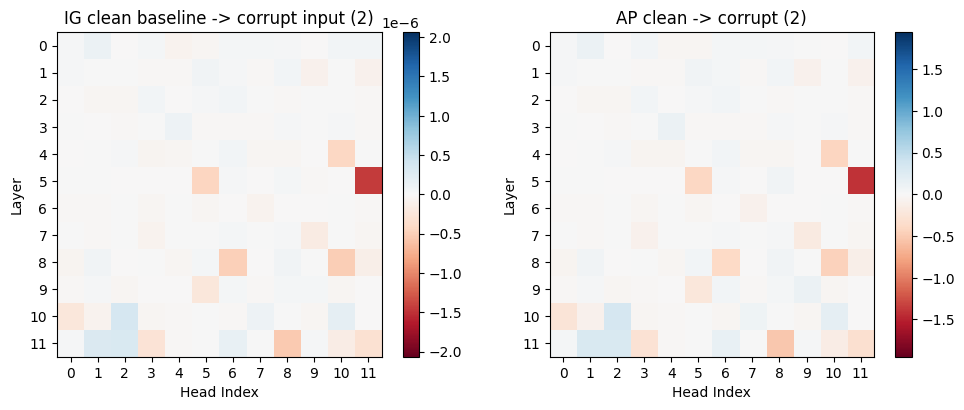

In [8]:
plot_attn_comparison(ig_clean_corrupt_attn[:3], ap_clean_corrupt_attn[:3], model, "IG clean baseline -> corrupt input", "AP clean -> corrupt")

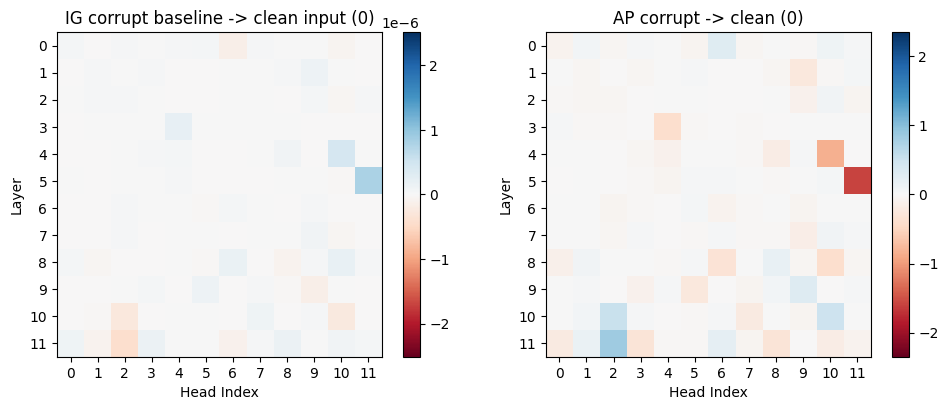

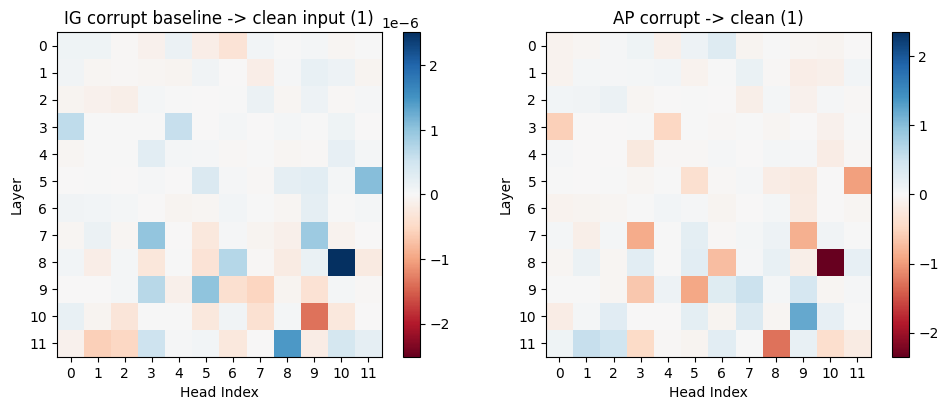

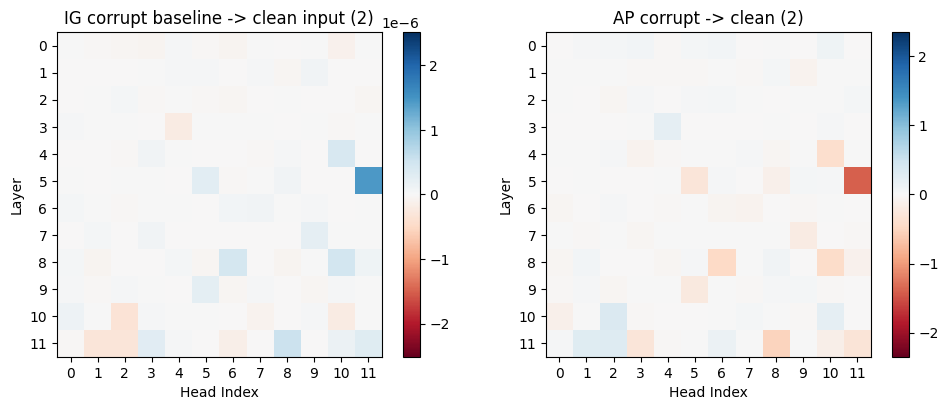

In [9]:
plot_attn_comparison(ig_corrupt_clean_attn[:3], ap_corrupt_clean_attn[:3], model, "IG corrupt baseline -> clean input", "AP corrupt -> clean")

Correlation between clean -> corrupt IG and AP


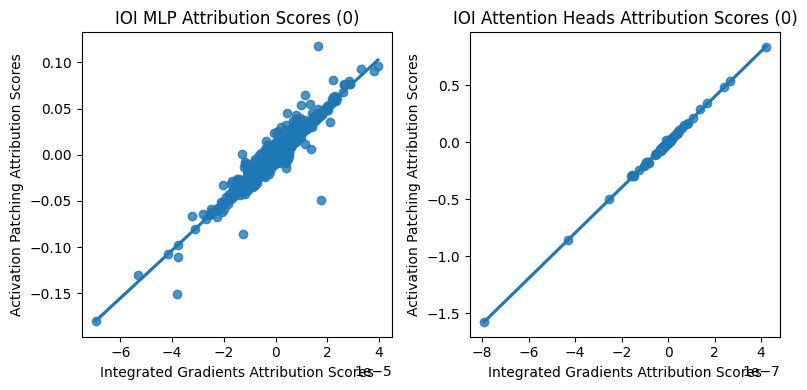

Correlation coefficient for neurons: 0.9781080393095625
Correlation coefficient for attention heads: 0.9996766519539676


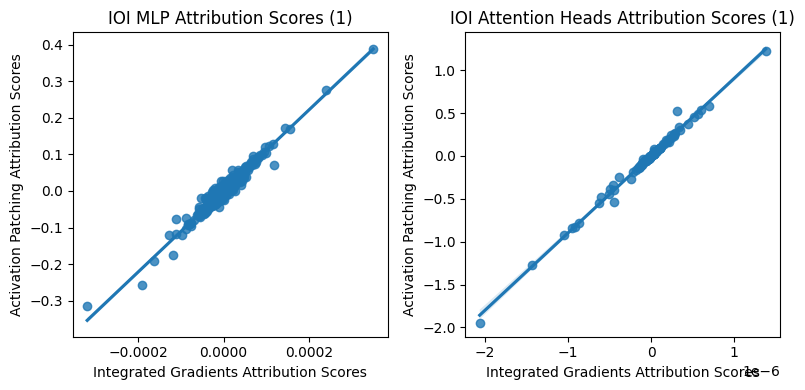

Correlation coefficient for neurons: 0.9806869207736839
Correlation coefficient for attention heads: 0.9951896333430784


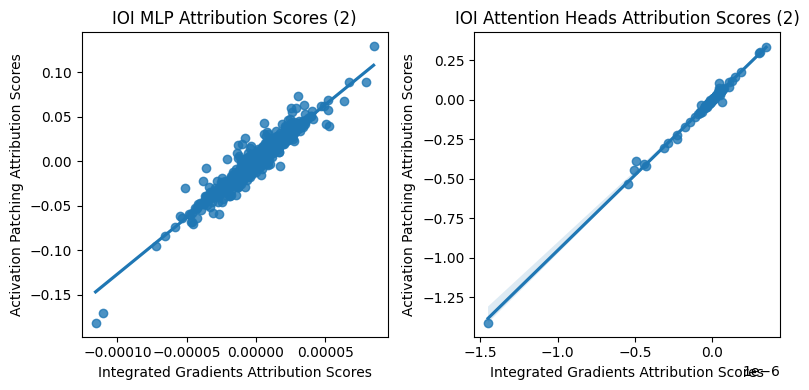

Correlation coefficient for neurons: 0.9757320311419594
Correlation coefficient for attention heads: 0.9967339352568454


In [11]:
print("Correlation between clean -> corrupt IG and AP")
plot_correlation_comparison(ig_clean_corrupt_mlp[:3], ap_clean_corrupt_mlp[:3], ig_clean_corrupt_attn[:3], ap_clean_corrupt_attn[:3], Task.IOI)

Correlation between corrupt -> clean IG and AP


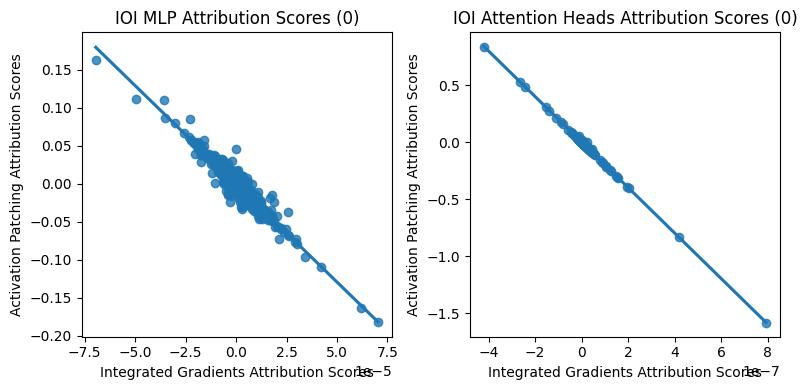

Correlation coefficient for neurons: -0.9813482434332876
Correlation coefficient for attention heads: -0.9994609854739294


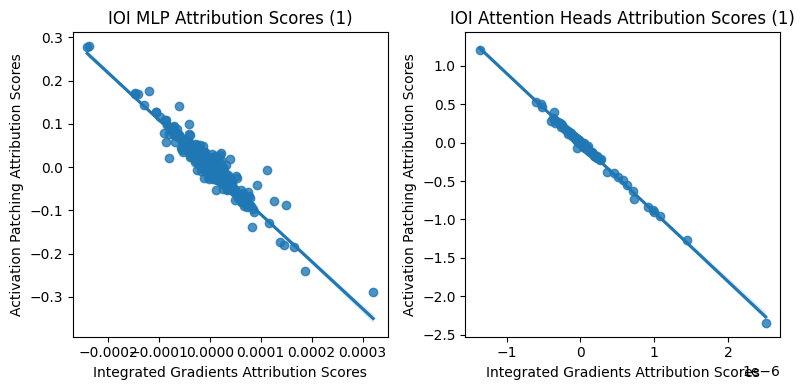

Correlation coefficient for neurons: -0.9675319208398431
Correlation coefficient for attention heads: -0.9980831403666831


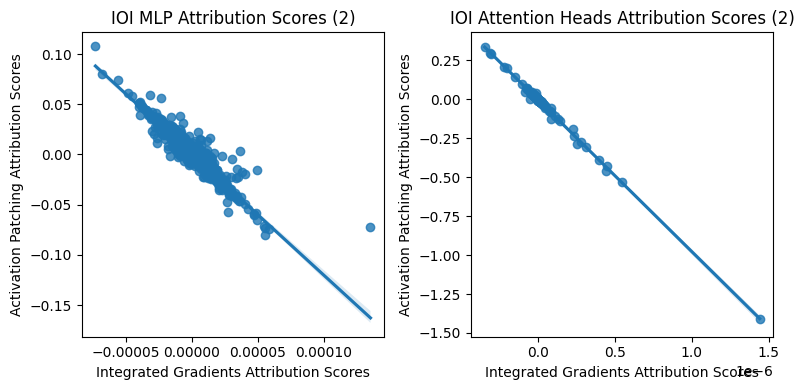

Correlation coefficient for neurons: -0.9675847810877175
Correlation coefficient for attention heads: -0.9983263095961261


In [12]:
print("Correlation between corrupt -> clean IG and AP")
plot_correlation_comparison(ig_corrupt_clean_mlp[:3], ap_corrupt_clean_mlp[:3], ig_corrupt_clean_attn[:3], ap_corrupt_clean_attn[:3], Task.IOI)

In [4]:
print(f"Average absolute correlation between clean->corrupt IG and AP (MLP): {average_correlation(ig_clean_corrupt_mlp, ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and AP (attention): {average_correlation(ig_clean_corrupt_attn, ap_clean_corrupt_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and AP (MLP): {average_correlation(ig_corrupt_clean_mlp, ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and AP (attention): {average_correlation(ig_corrupt_clean_attn, ap_corrupt_clean_attn)}")

Average absolute correlation between clean->corrupt IG and AP (MLP): (np.float64(0.7818885659407933), np.float64(0.5572793196006636))
Average absolute correlation between clean->corrupt IG and AP (attention): (np.float64(0.8163633394644311), np.float64(0.5707158276465426))
Average absolute correlation between corrupt->clean IG and AP (MLP): (np.float64(-0.7850361343326107), np.float64(0.5584697564728751))
Average absolute correlation between corrupt->clean IG and AP (attention): (np.float64(-0.8164543289351016), np.float64(0.5708316369037106))


To verify that clean -> corrupt and corrupt -> clean yield different results, we plot the correlation between IG and AP in non-corresponding directions.

In [5]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(ig_clean_corrupt_mlp, ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(ig_clean_corrupt_attn, ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(ig_corrupt_clean_mlp, ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(ig_corrupt_clean_attn, ap_clean_corrupt_attn)}")

Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): (np.float64(0.4611303997383419), np.float64(0.43982906568041474))
Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): (np.float64(0.7826156568087603), np.float64(0.5466910513177105))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): (np.float64(-0.4631245193581759), np.float64(0.4405873273692661))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): (np.float64(-0.7820861685452445), np.float64(0.5461494942730072))


Since the correlation is consistently lower between IG and AP in non-corresponding directions, this suggests that IG can approximate AP in the corresponding direction.

In [25]:
from attribution_methods import asymmetry_score

ig_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ig_clean_corrupt_mlp, is_ig=True)
ig_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ig_clean_corrupt_attn, is_ig=True)

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

print(f"Average correlation between AP and IG asymmetry for attention heads: {average_correlation(ap_attn_asymmetry, ig_attn_asymmetry)}")
print(f"Average correlation between AP and IG asymmetry for MLP neurons: {average_correlation(ap_mlp_asymmetry, ig_mlp_asymmetry)}")

mlp_disagreement = asymmetry_score(ig_corrupt_clean_mlp, ap_corrupt_clean_mlp, is_ig=False)
attn_disagreement = asymmetry_score(ig_corrupt_clean_attn, ap_corrupt_clean_attn, is_ig=False)
print(f"Correlation between disagreement and asymmetry for attention heads: {average_correlation(attn_disagreement, ap_attn_asymmetry)}")
print(f"Correlation between disagreement and asymmetry for MLP: {average_correlation(mlp_disagreement, ap_mlp_asymmetry)}")

exclusive_mlp = highlight_components(mlp_disagreement)[0]
exclusive_attn = highlight_components(attn_disagreement)[0]
latent_mlp = highlight_components(ap_mlp_asymmetry)[0]
latent_attn = highlight_components(ap_attn_asymmetry)[0]
print(f"Average overlap between exclusive components and latent neurons: {measure_overlap(exclusive_mlp, latent_mlp).mean()}, {measure_overlap(exclusive_mlp, latent_mlp).std()}")
print(f"Average overlap between exclusive components and latent attention heads: {measure_overlap(exclusive_attn, latent_attn).mean()}, {measure_overlap(exclusive_attn, latent_attn).std()}")

Average correlation between AP and IG asymmetry for attention heads: (np.float64(-0.7648895811025834), np.float64(0.5443200153498045))
Average correlation between AP and IG asymmetry for MLP neurons: (np.float64(-0.7661495519351667), np.float64(0.5307788997717975))
Correlation between disagreement and asymmetry for attention heads: (np.float64(-0.14589715534501366), np.float64(0.27450700903764963))
Correlation between disagreement and asymmetry for MLP: (np.float64(-0.44007477810575885), np.float64(0.16621650689845593))
Average overlap between exclusive components and latent neurons: 0.23414073884487152, 0.07947367429733276
Average overlap between exclusive components and latent attention heads: 0.17260044813156128, 0.12509609758853912


## Identifying latent components

We identify latent components as those with high attribution scores in clean->corrupt, but not in corrupt->clean (or vice versa). This is quantified using the asymmetry score, which is calculated as the difference between scores in opposite directions, normalised by maximum difference. A latent component should have an asymmetry score above one standard deviation (approximately 34%).

In [42]:
def asymmetry_score(corrupt_clean: Tensor, clean_corrupt: Tensor, is_ig: bool):
    assert corrupt_clean.shape == clean_corrupt.shape, \
        f"Cannot calculate asymmetry between matrices of different shapes, {corrupt_clean.shape} and {clean_corrupt.shape}"

    if is_ig:
        # Expect opposite directions to cancel out attribution scores
        max_scores = torch.amax((clean_corrupt + corrupt_clean), dim=(1,2), keepdim=True)
        return torch.div((corrupt_clean + clean_corrupt), max_scores)
    
    max_scores = torch.amax((corrupt_clean - clean_corrupt), dim=(1,2), keepdim=True)
    return torch.div((corrupt_clean - clean_corrupt), max_scores)

In [43]:
ig_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ig_clean_corrupt_mlp, is_ig=True)
ig_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ig_clean_corrupt_attn, is_ig=True)

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

### Latent components identified by IG vs. AP

We evaluate the extent of overlap between latent components identified using IG, and latent components identified using AP. We expect this number to be high if IG can approxiamte AP latent components.

Overlap between latent attention heads identified by IG vs AP: 0.5413497686386108


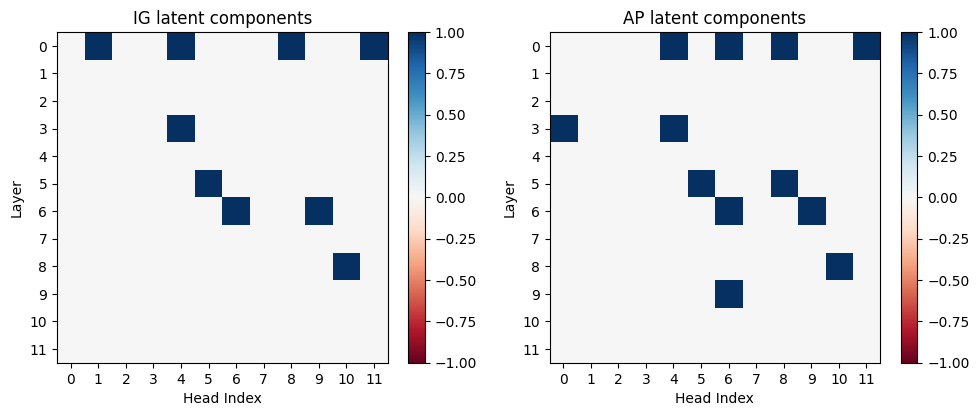

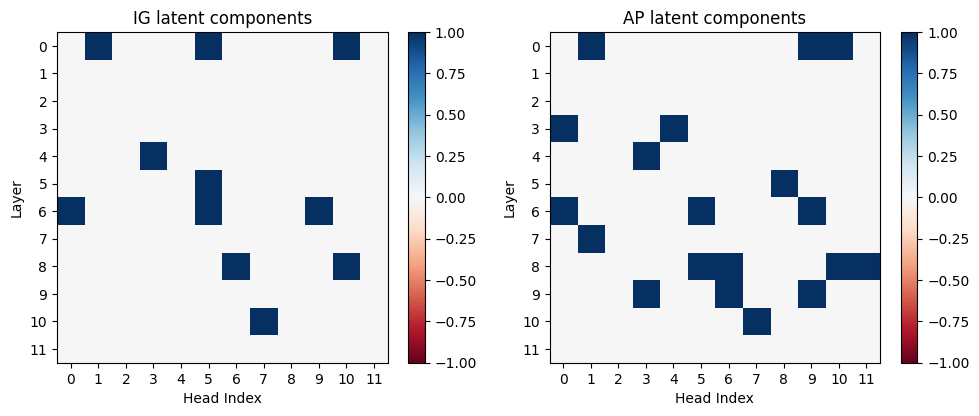

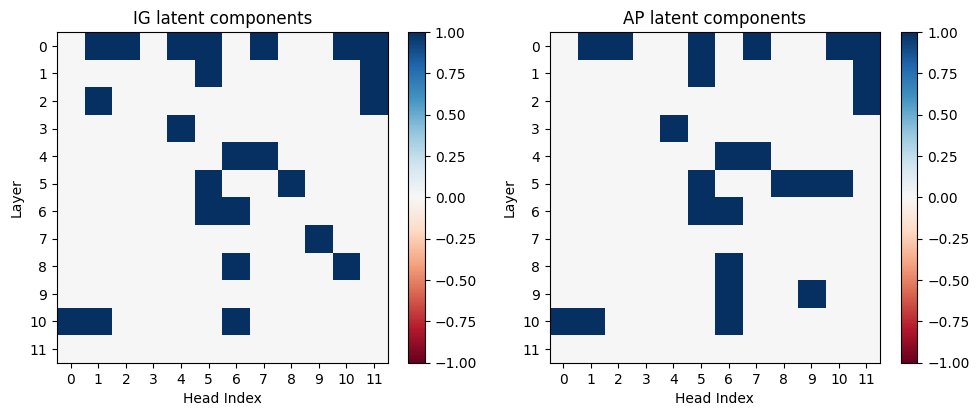

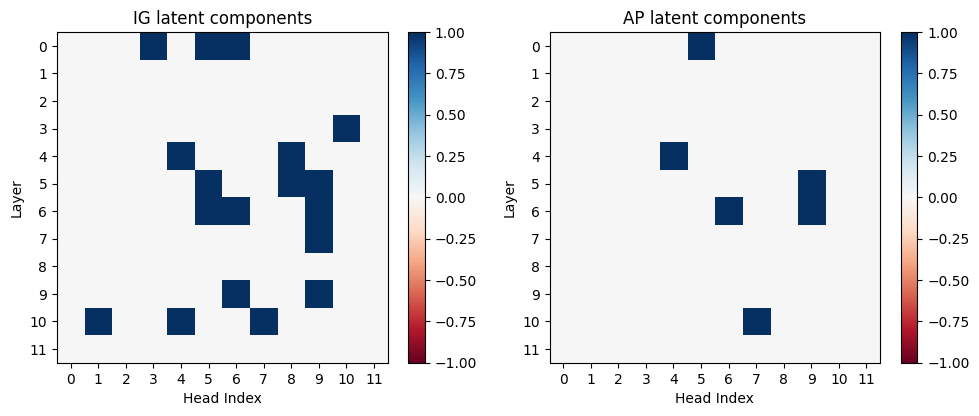

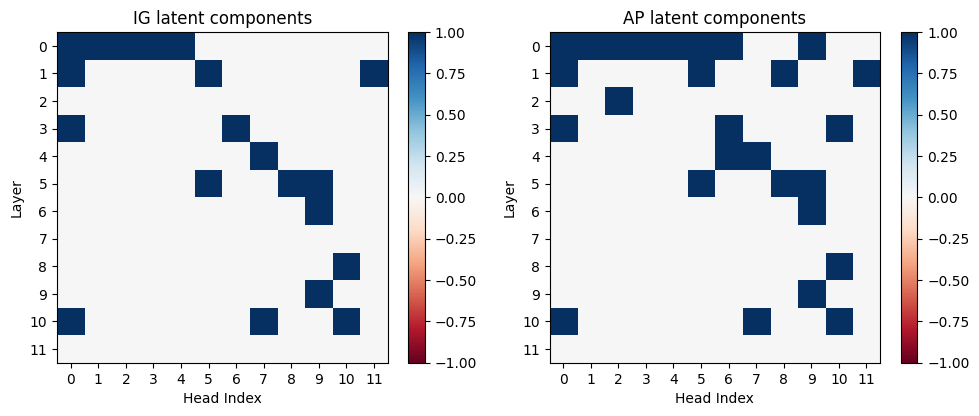

In [45]:
# TODO: rerun

latent_attn_ig = highlight_components(ig_attn_asymmetry)[0]
latent_attn_ap = highlight_components(ap_attn_asymmetry)[0]

latent_attn_overlap = measure_overlap(latent_attn_ig, latent_attn_ap)
mean_latent_attn_overlap = latent_attn_overlap.mean()
print(f"Overlap between latent attention heads identified by IG vs AP: {mean_latent_attn_overlap}")

plot_attn_comparison(latent_attn_ig[:5].int(), latent_attn_ap[:5].int(), model, "IG latent components", "AP latent components")

In [46]:
latent_mlp_ig = highlight_components(ig_mlp_asymmetry)[0]
latent_mlp_ap = highlight_components(ap_mlp_asymmetry)[0]

latent_mlp_overlap = measure_overlap(latent_mlp_ig, latent_mlp_ap)
mean_latent_mlp_overlap = latent_mlp_overlap.mean()
print(f"Overlap between latent MLP neurons identified by IG vs AP: {mean_latent_mlp_overlap}")

Overlap between latent MLP neurons identified by IG vs AP: 0.6339761018753052


###  Comparison to discrepancies

Hypothesis: components which are highlighted exclusively by one attribution method are latent components.

To evaluate this, we measure the overlap between components highlighted exclusively by one method, and components highlighted as latent components.

In [47]:
ig_attn_significant, ig_attn_significant_indices = highlight_components(ig_clean_corrupt_attn)
ap_attn_significant, ap_attn_significant_indices = highlight_components(ap_clean_corrupt_attn)

ig_attn_exclusive = ig_attn_significant & ~ap_attn_significant
ap_attn_exclusive = ap_attn_significant & ~ig_attn_significant

ig_attn_exclusive_overlap = measure_overlap(ig_attn_exclusive, latent_attn_ig)
ap_attn_exclusive_overlap = measure_overlap(ap_attn_exclusive, latent_attn_ig)

print(f"Overlap between IG-exclusive attention heads and latent attention heads: {ig_attn_exclusive_overlap.mean()}")
print(f"Overlap between AP-exclusive attention heads and latent attention heads: {ap_attn_exclusive_overlap.mean()}")

Overlap between IG-exclusive attention heads and latent attention heads: 0.026554109528660774
Overlap between AP-exclusive attention heads and latent attention heads: 0.09229083359241486


In [48]:
ig_mlp_significant, ig_mlp_significant_indices = highlight_components(ig_clean_corrupt_mlp)
ap_mlp_significant, ap_mlp_significant_indices = highlight_components(ap_clean_corrupt_mlp)

ig_mlp_exclusive = ig_mlp_significant & ~ap_mlp_significant
ap_mlp_exclusive = ap_mlp_significant & ~ig_mlp_significant

ig_mlp_exclusive_overlap = measure_overlap(ig_mlp_exclusive, latent_mlp_ig)
ap_mlp_exclusive_overlap = measure_overlap(ap_mlp_exclusive, latent_mlp_ig)

print(f"Overlap between IG-exclusive MLP neurons and latent MLP neurons: {ig_mlp_exclusive_overlap.mean()}")
print(f"Overlap between AP-exclusive MLP neurons and latent MLP neurons: {ap_mlp_exclusive_overlap.mean()}")

Overlap between IG-exclusive MLP neurons and latent MLP neurons: 0.020752785727381706
Overlap between AP-exclusive MLP neurons and latent MLP neurons: 0.13023918867111206


## Ablating latent components

Hypothesis: components with high asymmetry between patching directions are latent components which significantly affect performance if ablated alongside other components.

- OR components are identified by patching from clean -> corrupt only.
- AND components are identified by patching from corrupt -> clean only.

To test this, we ablate latent components and evaluate model performance using average logit difference:

1. Ablate all OR components at once.
2. Ablate all AND components at once.
3. Ablate all IG-AP components (those highlighted by both IG and AP at once).
4. Ablate all OR components and IG-AP components.
5. Ablate all AND components and IG-AP components.
6. Ablate all components highlighted by IG.
7. Ablate all components highlighted by AP.

### Experiment

In [6]:
# Baseline performance
model.reset_hooks()

logits = model(clean_input)
baseline_performance = logit_diff_metric(logits, labels)

print(f"Mean baseline performance: {baseline_performance.mean()} ± {baseline_performance.std()}")


Mean baseline performance: 0.5738021731376648 ± 2.046718120574951


In [7]:
# Ablate using mean corrupt activations
mean_corrupt_activations = dict()
for hook_name, act in corrupted_cache.cache_dict.items():
    mean_corrupt_activations[hook_name] = act.mean(dim=0)

In [53]:
# AND components: corrupt->clean detects, clean->corrupt does not detect
and_ig_attn_indices = highlight_components(ig_attn_asymmetry)[1]
and_ap_attn_indices = highlight_components(ap_attn_asymmetry)[1]
and_ig_mlp_indices = highlight_components(ig_mlp_asymmetry)[1]
and_ap_mlp_indices = highlight_components(ap_mlp_asymmetry)[1]

# OR components: corrupt->clean does not detect, clean->corrupt detects
or_ig_attn_indices = highlight_components(-ig_attn_asymmetry)[1]
or_ap_attn_indices = highlight_components(-ap_attn_asymmetry)[1]
or_ig_mlp_indices = highlight_components(-ig_mlp_asymmetry)[1]
or_ap_mlp_indices = highlight_components(-ap_mlp_asymmetry)[1]

In [54]:
# Components highlighted by both
ig_attn_set_indices = set([tuple(x) for x in ig_attn_significant_indices.tolist()])
ap_attn_set_indices = set([tuple(x) for x in ap_attn_significant_indices.tolist()])

both_attn_indices = list(ig_attn_set_indices.intersection(ap_attn_set_indices))

ig_mlp_set_indices = set([tuple(x) for x in ig_mlp_significant_indices.tolist()])
ap_mlp_set_indices = set([tuple(x) for x in ap_mlp_significant_indices.tolist()])
both_mlp_indices = list(ig_mlp_set_indices.intersection(ap_mlp_set_indices))

In [50]:
latent_ig_attn_ablation_scores = dict()
latent_ap_attn_ablation_scores = dict()

In [55]:
# 1. Ablate all OR components at once.
latent_ig_attn_ablation_scores["OR"] = test_multi_ablated_performance(
    model, or_ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["OR"] = test_multi_ablated_performance(
    model, or_ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 2. Ablate all AND components at once.
latent_ig_attn_ablation_scores["AND"] = test_multi_ablated_performance(
    model, and_ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["AND"] = test_multi_ablated_performance(
    model, and_ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
Mean performance: 0.4277520775794983, Std performance: 1.9041118621826172
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4289929270744324, Std performance: 1.905962347984314
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4277520775794983, Std performance: 1.9041118621826172
Test IOI performance with 100 samples of ablated components
Mean performance: 0.4289929270744324, Std performance: 1.905962347984314


In [56]:
# 3. Ablate all IG-AP components (those highlighted by both IG and AP at once).
both_attn_ablated_performance = test_multi_ablated_performance(
    model, both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ig_attn_ablation_scores["IG-AP"] = both_attn_ablated_performance
latent_ap_attn_ablation_scores["IG-AP"] = both_attn_ablated_performance

Test IOI performance with 100 samples of ablated components
Mean performance: 0.6015526652336121, Std performance: 2.1037890911102295


In [57]:
# 4. Ablate all OR components and IG-AP components.
latent_ig_attn_ablation_scores["OR + IG-AP"] = test_multi_ablated_performance(
    model, or_ig_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["OR + IG-AP"] = test_multi_ablated_performance(
    model, or_ap_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 5. Ablate all AND components and IG-AP components.
latent_ig_attn_ablation_scores["AND + IG-AP"] = test_multi_ablated_performance(
    model, and_ig_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)
latent_ap_attn_ablation_scores["AND + IG-AP"] = test_multi_ablated_performance(
    model, and_ap_attn_indices.tolist() + both_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
Mean performance: 0.49069082736968994, Std performance: 2.0430493354797363
Test IOI performance with 100 samples of ablated components
Mean performance: 0.49683964252471924, Std performance: 2.01023268699646
Test IOI performance with 100 samples of ablated components
Mean performance: 0.49069082736968994, Std performance: 2.0430493354797363
Test IOI performance with 100 samples of ablated components
Mean performance: 0.49683964252471924, Std performance: 2.01023268699646


In [58]:
# 6. Ablate all components highlighted by IG.
latent_ig_attn_ablation_scores["IG"] = test_multi_ablated_performance(
    model, ig_attn_significant_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# 7. Ablate all components highlighted by AP.
latent_ap_attn_ablation_scores["AP"] = test_multi_ablated_performance(
    model, ap_attn_significant_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

Test IOI performance with 100 samples of ablated components
Mean performance: 0.45906341075897217, Std performance: 1.962353229522705
Test IOI performance with 100 samples of ablated components
Mean performance: 0.6044026017189026, Std performance: 2.112431049346924


In [59]:
torch.save(latent_ig_attn_ablation_scores, "results/latent_components/ioi/latent_ig_attn_ablation_scores.pt")
torch.save(latent_ap_attn_ablation_scores, "results/latent_components/ioi/latent_ap_attn_ablation_scores.pt")

In [8]:
# SHORTHAND
from testing import run_latent_ablation_experiment

run_latent_ablation_experiment(model, ig_clean_corrupt_mlp, ig_clean_corrupt_attn, ap_clean_corrupt_mlp, ap_clean_corrupt_attn, ig_corrupt_clean_mlp, ig_corrupt_clean_attn, ap_corrupt_clean_mlp, ap_corrupt_clean_attn, Task.IOI)

Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.09356079250574112, Std performance difference: 0.3648415803909302
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.10755147784948349, Std performance difference: 0.35030296444892883
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.0013639938551932573, Std performance difference: 0.08531417697668076
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.0012249589199200273, Std performance difference: 0.08502178639173508
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.09356079250574112, Std performance difference: 0.3648415803909302
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.10755147784948349, Std performance difference: 0.35030296444892883
Test IOI performance with 100 samples of abla

### Analysis

To evaluate the impact of latent components, we compare the model performances under ablation.

In [10]:
latent_ig_attn_ablation_scores = torch.load("results/latent_components/ioi/latent_ig_attn_ablation_scores.pt")
latent_ap_attn_ablation_scores = torch.load("results/latent_components/ioi/latent_ap_attn_ablation_scores.pt")

latent_ig_mlp_ablation_scores = torch.load("results/latent_components/ioi/latent_ig_mlp_ablation_scores.pt")
latent_ap_mlp_ablation_scores = torch.load("results/latent_components/ioi/latent_ap_mlp_ablation_scores.pt")

In [14]:
latent_ig_mlp_ablation_scores, latent_ap_mlp_ablation_scores

({'Baseline': (tensor(0.5738), tensor(2.0467)),
  'OR': (tensor(0.0014), tensor(0.0853)),
  'AND': (tensor(0.0014), tensor(0.0853)),
  'IG-AP': (tensor(-0.0874), tensor(0.3534)),
  'OR + IG-AP': (tensor(-0.0863), tensor(0.3502)),
  'AND + IG-AP': (tensor(-0.0863), tensor(0.3502)),
  'IG': (tensor(-0.0539), tensor(0.3093))},
 {'Baseline': (tensor(0.5738), tensor(2.0467)),
  'OR': (tensor(-0.0012), tensor(0.0850)),
  'AND': (tensor(-0.0012), tensor(0.0850)),
  'IG-AP': (tensor(-0.0874), tensor(0.3534)),
  'OR + IG-AP': (tensor(-0.0863), tensor(0.3502)),
  'AND + IG-AP': (tensor(-0.0863), tensor(0.3502)),
  'AP': (tensor(-0.0638), tensor(0.2885))})

[0.5738021731376648, -0.09356079250574112, -0.09356079250574112, 0.08776365965604782, -0.045499347150325775, -0.045499347150325775, -0.10469783842563629]


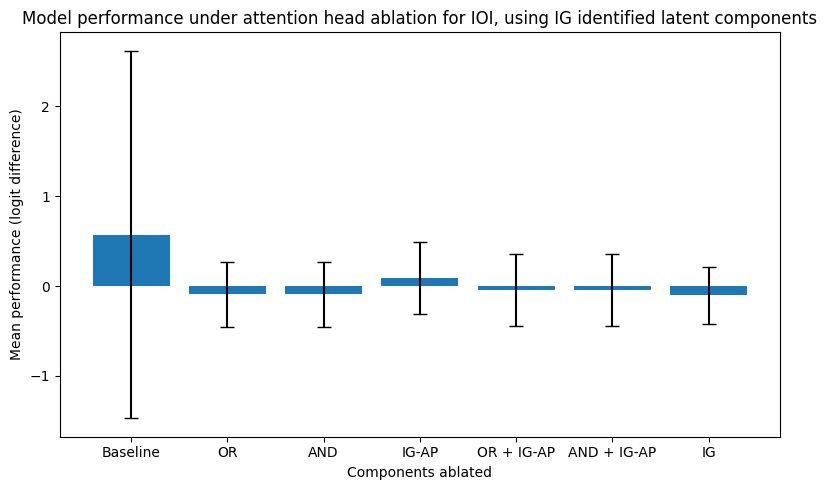

[0.5738021731376648, -0.10755147784948349, -0.10755147784948349, 0.08776365965604782, -0.041445065289735794, -0.041445065289735794, 0.08709023147821426]


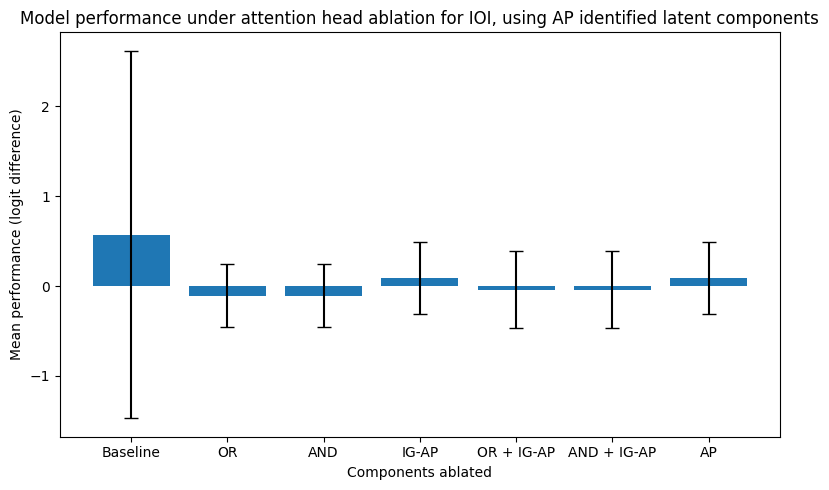

In [11]:
plot_bar_chart(
    latent_ig_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for IOI, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for IOI, using AP identified latent components",
    has_std=True)

[0.5738016366958618, 0.5751664638519287, 0.5751664638519287, 0.48639723658561707, 0.48753929138183594, 0.48753929138183594, 0.5198858380317688]


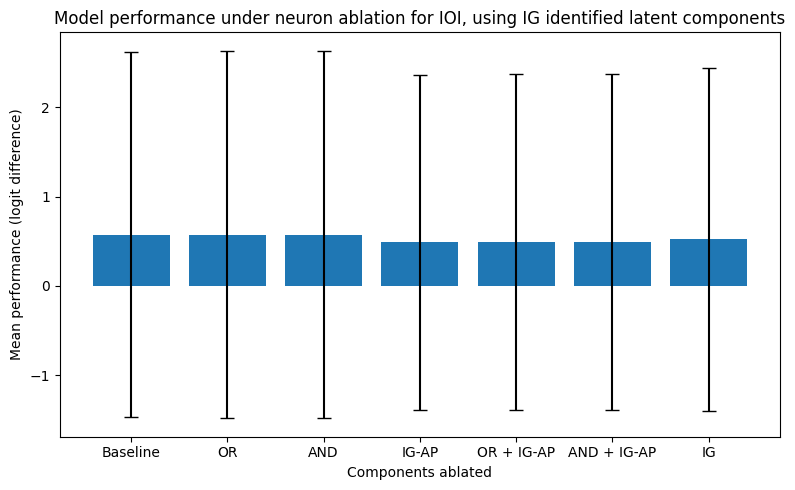

[0.5738016366958618, 0.5725772976875305, 0.5725772976875305, 0.48639723658561707, 0.48753929138183594, 0.48753929138183594, 0.5100203156471252]


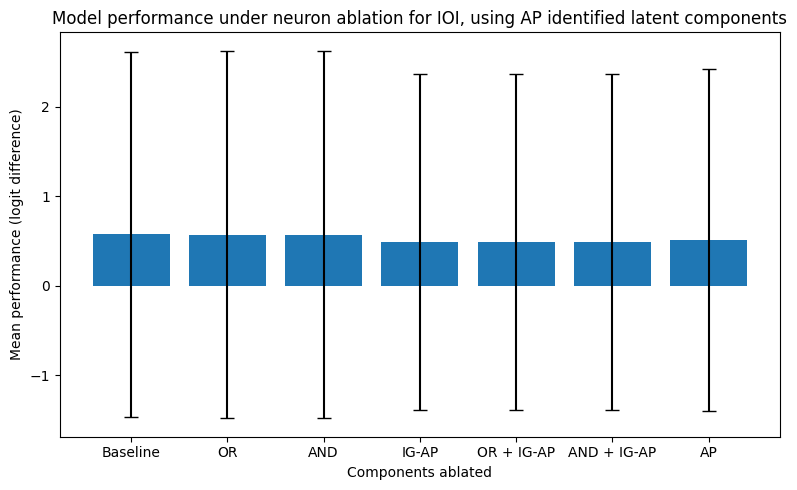

In [11]:
plot_bar_chart(
    latent_ig_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for IOI, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for IOI, using AP identified latent components",
    has_std=True)

## Generalisation

Hypothesis: IG can approximate AP in the corresponding direction for multiple tasks.

### Greater-Than

In [15]:
from testing import greater_than_prob_diff_metric

greater_than_dataset = TaskDataset(Task.GREATER_THAN)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(model, clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(model, corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([ 0.8670,  0.8998,  0.9046,  0.8931,  0.8261,  0.8083,  0.9399,  0.8767,
         0.7247,  0.9015,  0.8210,  0.8544,  0.8492,  0.8597,  0.9377,  0.5882,
         0.8244,  0.8729,  0.9530,  0.8655,  0.9432,  0.9268,  0.8044,  0.8718,
         0.6772,  0.8514,  0.8844,  0.8216,  0.8870,  0.7221,  0.9517,  0.8526,
         0.8055,  0.8832,  0.7858,  0.4179,  0.9520,  0.8633,  0.8283,  0.9166,
         0.9020,  0.7755,  0.6411,  0.8366,  0.8993,  0.9411,  0.9138,  0.7848,
         0.8788,  0.8683,  0.4046,  0.8780,  0.9316,  0.8202,  0.8017,  0.8528,
         0.8538,  0.8295,  0.8560,  0.8585,  0.8936,  0.9062,  0.8381,  0.9049,
         0.0631,  0.9226, -0.1883,  0.9213,  0.8439,  0.8605,  0.3895,  0.9208,
         0.8139,  0.8789,  0.8855,  0.9023,  0.5799,  0.8774,  0.8771,  0.9171,
         0.8438, -0.0192,  0.8881,  0.9197,  0.8702,  0.6880,  0.8587,  0.9462,
         0.8470,  0.6209,  0.7185,  0.7852,  0.8294,  0.9640,  0.8169,  0.9211,
         0.9457,

In [16]:
from functools import partial

greater_than_metric = partial(greater_than_prob_diff_metric, model)

In [21]:
greater_than_ig_clean_corrupt_mlp, greater_than_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_metric, labels)

torch.save(greater_than_ig_clean_corrupt_mlp, "results/latent_components/greater_than/ig_clean_corrupt_mlp.pt")
torch.save(greater_than_ig_clean_corrupt_attn, "results/latent_components/greater_than/ig_clean_corrupt_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-7.0781e-08,  6.5565e-07, -7.4506e-09, -1.0207e-06,  1.2293e-06,
         1.0431e-07, -2.7567e-07, -1.0729e-06,  7.1526e-07,  8.5682e-07,
         2.4997e-06,  1.0058e-07, -6.7987e-07, -9.1642e-07, -5.1782e-07,
         3.3081e-06, -2.0117e-07, -6.7800e-07,  9.1270e-08,  6.2585e-07,
         4.3958e-07, -7.0781e-08, -9.5367e-07,  2.7753e-07, -1.6987e-06,
         0.0000e+00, -2.3805e-06,  5.8115e-07,  4.8429e-08, -8.9407e-07,
        -7.4506e-09,  1.4380e-06,  1.9632e-06, -1.1548e-07,  1.4454e-06,
         5.9903e-06,  7.4506e-09, -2.0489e-06,  3.4273e-07,  7.5623e-07,
        -4.4703e-07,  1.4901e-07,  2.1011e-06,  9.9838e-07, -1.7434e-06,
        -2.7008e-08,  1.7881e-07, -3.2783e-07,  1.2666e-07,  2.5108e-06,
        -3.6657e-06,  8.8289e-07, -1.1772e-06,  1.0431e-06, -9.5367e-07,
         1.8701e-06, -2.1458e-06, -8.9407e-08,  1.2666e-06,  1.1325e-06,
         7.7486e-07, -5.6624e-07, -2.0936e-06, -9.7603e-07,  5.245

In [22]:
greater_than_ap_clean_corrupt_mlp, greater_than_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, greater_than_metric, labels)

torch.save(greater_than_ap_clean_corrupt_mlp, "results/latent_components/greater_than/ap_clean_corrupt_mlp.pt")
torch.save(greater_than_ap_clean_corrupt_attn, "results/latent_components/greater_than/ap_clean_corrupt_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [23]:
greater_than_ig_corrupt_clean_mlp, greater_than_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, greater_than_metric, labels)

torch.save(greater_than_ig_corrupt_clean_mlp, "results/latent_components/greater_than/ig_corrupt_clean_mlp.pt")
torch.save(greater_than_ig_corrupt_clean_attn, "results/latent_components/greater_than/ig_corrupt_clean_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.9670e-06, -2.3842e-06,  2.2650e-06, -4.4703e-08,  8.8662e-07,
        -1.7136e-07,  4.0233e-07, -7.5251e-07, -9.2760e-07,  4.1127e-06,
         1.1921e-06,  7.1526e-07, -2.7567e-06, -3.2783e-07,  1.2219e-06,
        -1.3970e-07, -7.8976e-07, -1.0133e-06, -2.0750e-06, -2.2128e-06,
        -1.1921e-06,  1.1027e-06,  1.1772e-06,  2.5332e-06, -1.7434e-06,
         5.0664e-07,  3.3379e-06,  1.4901e-06, -5.6624e-07, -5.8860e-07,
         4.1723e-07, -1.7881e-06, -2.4587e-07,  2.1756e-06, -3.9488e-07,
         2.7381e-07, -3.6359e-06, -1.5497e-06, -2.6152e-06,  3.5763e-07,
         1.3411e-07,  1.1474e-06, -4.1351e-07, -1.0431e-06, -8.1956e-07,
        -8.9407e-07,  6.9067e-06,  3.7700e-06,  3.5986e-06, -1.2219e-06,
        -1.1921e-07,  2.7418e-06,  5.0366e-06, -2.5630e-06,  1.6540e-06,
        -6.7055e-07,  1.9073e-06, -5.9605e-08,  4.2468e-07,  1.9372e-07,
        -6.8545e-07, -6.5565e-07, -1.3113e-06,  2.9206e-06,  6.966

In [24]:
greater_than_ap_corrupt_clean_mlp, greater_than_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_logit_diff, clean_cache, clean_logit_diff, greater_than_metric, labels)

torch.save(greater_than_ap_corrupt_clean_mlp, "results/latent_components/greater_than/ap_corrupt_clean_mlp.pt")
torch.save(greater_than_ap_corrupt_clean_attn, "results/latent_components/greater_than/ap_corrupt_clean_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [17]:
greater_than_ig_corrupt_clean_mlp = torch.load("results/latent_components/greater_than/ig_corrupt_clean_mlp.pt")
greater_than_ap_corrupt_clean_mlp = torch.load("results/latent_components/greater_than/ap_corrupt_clean_mlp.pt")
greater_than_ig_corrupt_clean_attn = torch.load("results/latent_components/greater_than/ig_corrupt_clean_attn.pt")
greater_than_ap_corrupt_clean_attn = torch.load("results/latent_components/greater_than/ap_corrupt_clean_attn.pt")
greater_than_ig_clean_corrupt_mlp = torch.load("results/latent_components/greater_than/ig_clean_corrupt_mlp.pt")
greater_than_ap_clean_corrupt_mlp = torch.load("results/latent_components/greater_than/ap_clean_corrupt_mlp.pt")
greater_than_ig_clean_corrupt_attn = torch.load("results/latent_components/greater_than/ig_clean_corrupt_attn.pt")
greater_than_ap_clean_corrupt_attn = torch.load("results/latent_components/greater_than/ap_clean_corrupt_attn.pt")

In [7]:
print(f"Average absolute correlation between clean->corrupt IG and AP (MLP): {average_correlation(greater_than_ig_clean_corrupt_mlp, greater_than_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and AP (attention): {average_correlation(greater_than_ig_clean_corrupt_attn, greater_than_ap_clean_corrupt_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and AP (MLP): {average_correlation(greater_than_ig_corrupt_clean_mlp, greater_than_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and AP (attention): {average_correlation(greater_than_ig_corrupt_clean_attn, greater_than_ap_corrupt_clean_attn)}")

Average absolute correlation between clean->corrupt IG and AP (MLP): (np.float64(0.8926193748277934), np.float64(0.05928539242830199))
Average absolute correlation between clean->corrupt IG and AP (attention): (np.float64(0.9943753101145123), np.float64(0.0035370948947849646))
Average absolute correlation between corrupt->clean IG and AP (MLP): (np.float64(-0.950028224632615), np.float64(0.0478091864012296))
Average absolute correlation between corrupt->clean IG and AP (attention): (np.float64(-0.9951088533514699), np.float64(0.00443407890198197))


In [8]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(greater_than_ig_clean_corrupt_mlp, greater_than_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(greater_than_ig_clean_corrupt_attn, greater_than_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(greater_than_ig_corrupt_clean_mlp, greater_than_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(greater_than_ig_corrupt_clean_attn, greater_than_ap_clean_corrupt_attn)}")

Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): (np.float64(0.7484657883400879), np.float64(0.07702311644368141))
Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): (np.float64(0.8854224068512893), np.float64(0.051784601665274495))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): (np.float64(-0.7115374276925995), np.float64(0.09509453033828724))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): (np.float64(-0.8676008173166732), np.float64(0.05833690941069029))


In [30]:
greater_than_ig_mlp_asymmetry = asymmetry_score(greater_than_ig_corrupt_clean_mlp, greater_than_ig_clean_corrupt_mlp, is_ig=True)
greater_than_ig_attn_asymmetry = asymmetry_score(greater_than_ig_corrupt_clean_attn, greater_than_ig_clean_corrupt_attn, is_ig=True)
greater_than_ap_mlp_asymmetry = asymmetry_score(greater_than_ap_corrupt_clean_mlp, greater_than_ap_clean_corrupt_mlp, is_ig=False)
greater_than_ap_attn_asymmetry = asymmetry_score(greater_than_ap_corrupt_clean_attn, greater_than_ap_clean_corrupt_attn, is_ig=False)
print(f"Average correlation between AP and IG asymmetry for attention heads: {average_correlation(greater_than_ap_attn_asymmetry, greater_than_ig_attn_asymmetry)}")
print(f"Average correlation between AP and IG asymmetry for MLP neurons: {average_correlation(greater_than_ap_mlp_asymmetry, greater_than_ig_mlp_asymmetry)}")

greater_than_mlp_disagreement = asymmetry_score(greater_than_ig_corrupt_clean_mlp, greater_than_ap_corrupt_clean_mlp, is_ig=False)
greater_than_attn_disagreement = asymmetry_score(greater_than_ig_corrupt_clean_attn, greater_than_ap_corrupt_clean_attn, is_ig=False)
print(f"Correlation between disagreement and asymmetry for attention heads: {average_correlation(greater_than_attn_disagreement, greater_than_ap_attn_asymmetry)}")
print(f"Correlation between disagreement and asymmetry for MLP: {average_correlation(greater_than_mlp_disagreement, greater_than_ap_mlp_asymmetry)}")

greater_than_exclusive_mlp = highlight_components(greater_than_mlp_disagreement)[0]
greater_than_exclusive_attn = highlight_components(greater_than_attn_disagreement)[0]
greater_than_latent_mlp = highlight_components(greater_than_ap_mlp_asymmetry)[0]
greater_than_latent_attn = highlight_components(greater_than_ap_attn_asymmetry)[0]
print(f"Average overlap between exclusive components and latent neurons: {measure_overlap(greater_than_exclusive_mlp, greater_than_latent_mlp).mean()}, {measure_overlap(greater_than_exclusive_mlp, greater_than_latent_mlp).std()}")
print(f"Average overlap between exclusive components and latent attention heads: {measure_overlap(greater_than_exclusive_attn, greater_than_latent_attn).mean()}, {measure_overlap(greater_than_exclusive_attn, greater_than_latent_attn).std()}")

Average correlation between AP and IG asymmetry for attention heads: (np.float64(-0.9919314000367357), np.float64(0.009800438933340459))
Average correlation between AP and IG asymmetry for MLP neurons: (np.float64(-0.9177835422457796), np.float64(0.05092280108902034))
Correlation between disagreement and asymmetry for attention heads: (np.float64(-0.5651949998636597), np.float64(0.6627473338275752))
Correlation between disagreement and asymmetry for MLP: (np.float64(-0.661115430990365), np.float64(0.46655894844675677))
Average overlap between exclusive components and latent neurons: 0.48746535181999207, 0.21433418989181519
Average overlap between exclusive components and latent attention heads: 0.6237308382987976, 0.18271183967590332


In [28]:
latent_ig_attn_ablation_scores = torch.load("results/latent_components/greater_than/latent_ig_attn_ablation_scores.pt")
latent_ap_attn_ablation_scores = torch.load("results/latent_components/greater_than/latent_ap_attn_ablation_scores.pt")

latent_ig_mlp_ablation_scores = torch.load("results/latent_components/greater_than/latent_ig_mlp_ablation_scores.pt")
latent_ap_mlp_ablation_scores = torch.load("results/latent_components/greater_than/latent_ap_mlp_ablation_scores.pt")

latent_ap_attn_ablation_scores

{'Baseline': (tensor(0.8149, device='cuda:0'),
  tensor(0.1884, device='cuda:0')),
 'OR': (tensor(0.5954), tensor(2.1057)),
 'AND': (tensor(0.5954), tensor(2.1057)),
 'IG-AP': (tensor(0.6148), tensor(2.1372)),
 'OR + IG-AP': (tensor(0.6056), tensor(2.1226)),
 'AND + IG-AP': (tensor(0.6056), tensor(2.1226)),
 'AP': (tensor(0.6201), tensor(2.1286))}

Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.1685822457075119, Std performance difference: 2.221376419067383
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.21946458518505096, Std performance difference: 2.108476400375366
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.23777653276920319, Std performance difference: 2.047366142272949
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.24398818612098694, Std performance difference: 2.028632164001465
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.1685822457075119, Std performance difference: 2.221376419067383
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.21946458518505096, Std performance difference: 2.108476400375366
Test IOI performance with 100 samples of ablated components


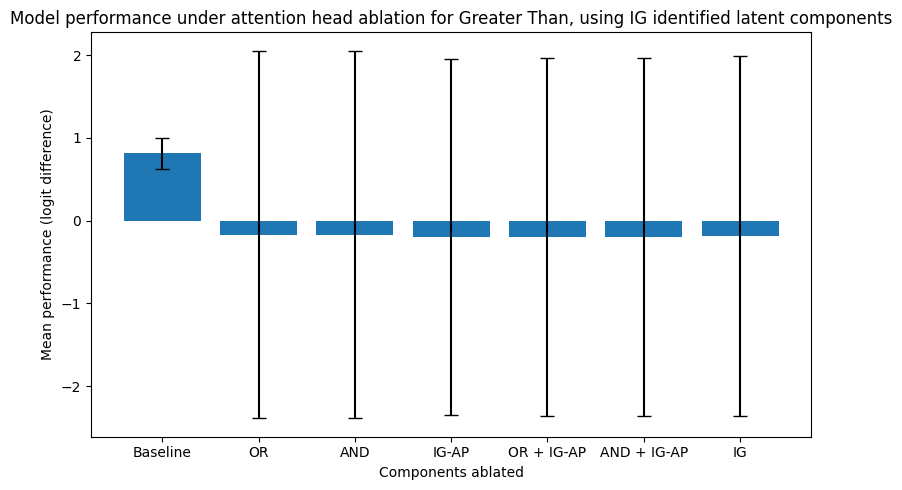

[0.8148627281188965, -0.21946458518505096, -0.21946458518505096, -0.2000766545534134, -0.20924478769302368, -0.20924478769302368, -0.19480544328689575]


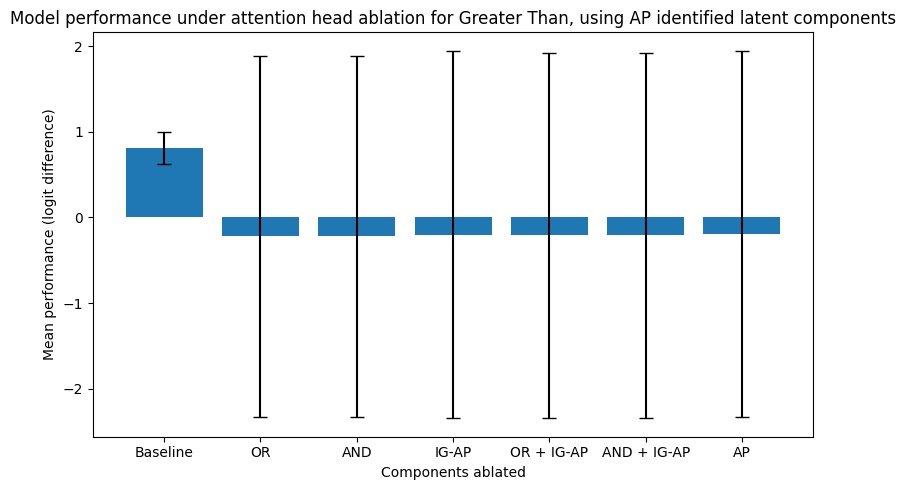

[0.8148627281188965, -0.23777653276920319, -0.23777653276920319, -0.25118598341941833, -0.25118598341941833, -0.25118598341941833, -0.2592568099498749]


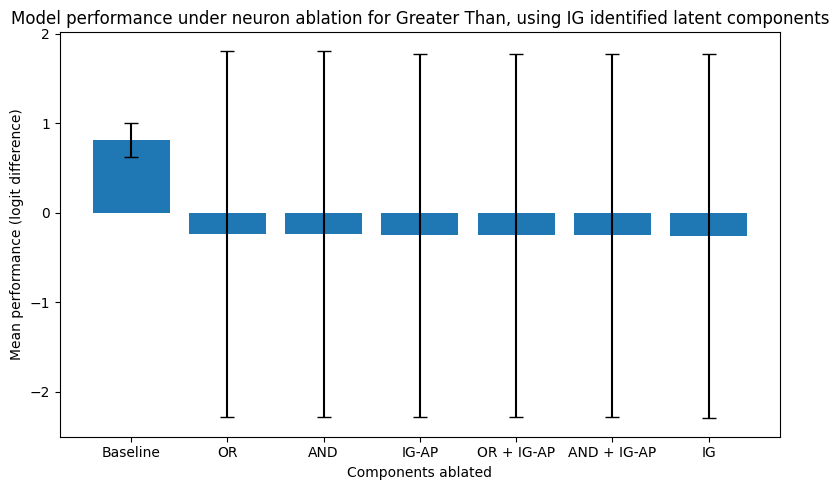

[0.8148627281188965, -0.24398818612098694, -0.24398818612098694, -0.25118598341941833, -0.25118598341941833, -0.25118598341941833, -0.2544896602630615]


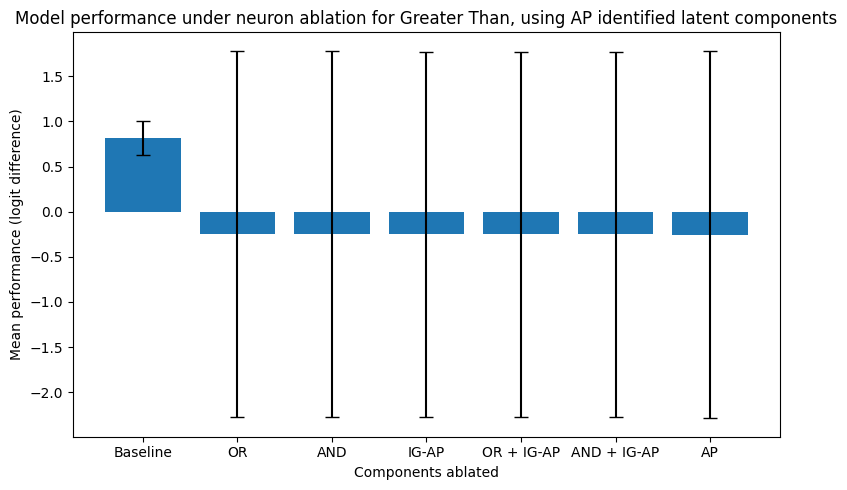

In [18]:
run_latent_ablation_experiment(model, greater_than_ig_clean_corrupt_mlp, greater_than_ig_clean_corrupt_attn, greater_than_ap_clean_corrupt_mlp, greater_than_ap_clean_corrupt_attn, greater_than_ig_corrupt_clean_mlp, greater_than_ig_corrupt_clean_attn, greater_than_ap_corrupt_clean_mlp, greater_than_ap_corrupt_clean_attn, Task.GREATER_THAN)

latent_ig_attn_ablation_scores = torch.load("results/latent_components/greater_than/latent_ig_attn_ablation_scores.pt")
latent_ap_attn_ablation_scores = torch.load("results/latent_components/greater_than/latent_ap_attn_ablation_scores.pt")

latent_ig_mlp_ablation_scores = torch.load("results/latent_components/greater_than/latent_ig_mlp_ablation_scores.pt")
latent_ap_mlp_ablation_scores = torch.load("results/latent_components/greater_than/latent_ap_mlp_ablation_scores.pt")

plot_bar_chart(
    latent_ig_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Greater Than, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Greater Than, using AP identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ig_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Greater Than, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Greater Than, using AP identified latent components",
    has_std=True)

In [19]:
latent_ig_attn_ablation_scores, latent_ap_attn_ablation_scores, latent_ig_mlp_ablation_scores, latent_ap_mlp_ablation_scores

({'Baseline': (tensor(0.8149), tensor(0.1884)),
  'OR': (tensor(-0.1686), tensor(2.2214)),
  'AND': (tensor(-0.1686), tensor(2.2214)),
  'IG-AP': (tensor(-0.2001), tensor(2.1472)),
  'OR + IG-AP': (tensor(-0.1977), tensor(2.1593)),
  'AND + IG-AP': (tensor(-0.1977), tensor(2.1593)),
  'IG': (tensor(-0.1886), tensor(2.1727))},
 {'Baseline': (tensor(0.8149), tensor(0.1884)),
  'OR': (tensor(-0.2195), tensor(2.1085)),
  'AND': (tensor(-0.2195), tensor(2.1085)),
  'IG-AP': (tensor(-0.2001), tensor(2.1472)),
  'OR + IG-AP': (tensor(-0.2092), tensor(2.1328)),
  'AND + IG-AP': (tensor(-0.2092), tensor(2.1328)),
  'AP': (tensor(-0.1948), tensor(2.1391))},
 {'Baseline': (tensor(0.8149), tensor(0.1884)),
  'OR': (tensor(-0.2378), tensor(2.0474)),
  'AND': (tensor(-0.2378), tensor(2.0474)),
  'IG-AP': (tensor(-0.2512), tensor(2.0267)),
  'OR + IG-AP': (tensor(-0.2512), tensor(2.0267)),
  'AND + IG-AP': (tensor(-0.2512), tensor(2.0267)),
  'IG': (tensor(-0.2593), tensor(2.0355))},
 {'Baseline': (t

### Capital Country

In [20]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.8200e+00, -2.5300e+00, -2.0190e+00,  6.3455e+00, -5.2652e-01,
         9.5128e-01,  8.3470e-01, -1.4007e+00,  2.1496e+00, -3.0366e+00,
        -1.9888e+00, -2.4605e+00,  1.8581e+00, -2.1915e+00,  4.4449e-01,
        -2.5304e+00, -1.0142e+00, -4.1188e-01,  1.6885e+00,  7.7189e-01,
        -2.6999e+00, -2.8442e+00, -4.1971e+00,  9.2689e-01,  4.0291e+00,
        -2.2892e+00, -6.7081e-01,  1.0529e+00,  1.0367e+00, -8.7463e-01,
         3.9553e+00,  6.6132e-01,  8.6297e-02, -3.7175e+00, -2.3759e-01,
         3.5704e+00, -2.3199e+00,  1.8338e+00,  3.1291e+00, -1.4578e+00,
         1.1065e-03,  6.2353e+00,  1.2950e+00, -8.1944e-01,  2.0202e-01,
        -2.4481e+00, -4.8091e+00,  1.0870e+00,  7.8114e-01, -3.3017e-01,
         2.4613e+00,  1.4654e+00,  3.8742e-01,  2.1720e+00, -2.4098e-01,
        -1.7736e+00,  1.3818e+00,  4.6563e+00,  7.5079e-01,  1.9365e+00,
        -2.5477e+00, -8.0683e-01, -2.5662e+00, -4.0473e-01, -1.6847e+00,
         3.6113e-01,  1.270

In [ ]:
capital_country_ig_clean_corrupt_mlp, capital_country_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_clean_corrupt_mlp, "results/latent_components/capital_country/ig_clean_corrupt_mlp.pt")
torch.save(capital_country_ig_clean_corrupt_attn, "results/latent_components/capital_country/ig_clean_corrupt_attn.pt")

In [97]:
capital_country_ap_clean_corrupt_mlp, capital_country_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_clean_corrupt_mlp, "results/latent_components/capital_country/ap_clean_corrupt_mlp.pt")
torch.save(capital_country_ap_clean_corrupt_attn, "results/latent_components/capital_country/ap_clean_corrupt_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [98]:
capital_country_ig_corrupt_clean_mlp, capital_country_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_corrupt_clean_mlp, "results/latent_components/capital_country/ig_corrupt_clean_mlp.pt")
torch.save(capital_country_ig_corrupt_clean_attn, "results/latent_components/capital_country/ig_corrupt_clean_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.6785e-06,  3.7421e-06,  9.6112e-07,  3.2485e-06,  1.7434e-06,
        -2.4550e-06, -2.0862e-07, -2.1178e-06,  1.1129e-07, -1.7751e-06,
        -2.9635e-06, -2.3302e-06, -3.2131e-07, -6.4075e-07, -2.5611e-06,
        -1.8030e-06,  1.9837e-07,  1.4454e-06,  7.2829e-07, -1.0356e-06,
        -1.4119e-06, -5.7090e-07, -2.8387e-06,  3.6135e-06, -1.5438e-05,
        -6.1095e-07, -2.4959e-07,  7.7486e-07, -7.0874e-07, -7.5996e-07,
         1.4082e-06,  2.7418e-06, -5.1968e-07, -1.9222e-06, -9.9093e-07,
        -1.9930e-06, -2.3842e-07, -7.4506e-07, -7.7486e-07,  1.6540e-06,
        -1.8030e-06,  3.9488e-07, -4.7535e-06, -7.1526e-07, -3.1479e-06,
         1.7490e-06,  3.5502e-06, -2.6524e-06,  4.5002e-06, -3.6322e-07,
        -1.3448e-06,  1.4901e-06,  1.9297e-06,  7.6368e-07, -2.4214e-06,
        -1.1101e-06,  1.6503e-06, -4.0978e-07, -1.8962e-06,  5.7369e-07,
         1.5851e-06,  1.0394e-06,  4.4554e-06,  1.8179e-06, -1.740

In [99]:
capital_country_ap_corrupt_clean_mlp, capital_country_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_corrupt_clean_mlp, "results/latent_components/capital_country/ap_corrupt_clean_mlp.pt")
torch.save(capital_country_ap_corrupt_clean_attn, "results/latent_components/capital_country/ap_corrupt_clean_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [21]:
capital_country_ig_corrupt_clean_mlp = torch.load("results/latent_components/capital_country/ig_corrupt_clean_mlp.pt")
capital_country_ap_corrupt_clean_mlp = torch.load("results/latent_components/capital_country/ap_corrupt_clean_mlp.pt")
capital_country_ig_corrupt_clean_attn = torch.load("results/latent_components/capital_country/ig_corrupt_clean_attn.pt")
capital_country_ap_corrupt_clean_attn = torch.load("results/latent_components/capital_country/ap_corrupt_clean_attn.pt")
capital_country_ig_clean_corrupt_mlp = torch.load("results/latent_components/capital_country/ig_clean_corrupt_mlp.pt")
capital_country_ap_clean_corrupt_mlp = torch.load("results/latent_components/capital_country/ap_clean_corrupt_mlp.pt")
capital_country_ig_clean_corrupt_attn = torch.load("results/latent_components/capital_country/ig_clean_corrupt_attn.pt")
capital_country_ap_clean_corrupt_attn = torch.load("results/latent_components/capital_country/ap_clean_corrupt_attn.pt")

In [10]:
print(f"Average absolute correlation between clean->corrupt IG and AP (MLP): {average_correlation(capital_country_ig_clean_corrupt_mlp, capital_country_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and AP (attention): {average_correlation(capital_country_ig_clean_corrupt_attn, capital_country_ap_clean_corrupt_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and AP (MLP): {average_correlation(capital_country_ig_corrupt_clean_mlp, capital_country_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and AP (attention): {average_correlation(capital_country_ig_corrupt_clean_attn, capital_country_ap_corrupt_clean_attn)}")

Average absolute correlation between clean->corrupt IG and AP (MLP): (np.float64(0.6519729627536308), np.float64(0.6756591357188685))
Average absolute correlation between clean->corrupt IG and AP (attention): (np.float64(0.6969040447091495), np.float64(0.7085664330459217))
Average absolute correlation between corrupt->clean IG and AP (MLP): (np.float64(-0.6571319857008199), np.float64(0.6744130606181749))
Average absolute correlation between corrupt->clean IG and AP (attention): (np.float64(-0.6966701111544906), np.float64(0.7090641449951534))


In [11]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(capital_country_ig_clean_corrupt_mlp, capital_country_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(capital_country_ig_clean_corrupt_attn, capital_country_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(capital_country_ig_corrupt_clean_mlp, capital_country_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(capital_country_ig_corrupt_clean_attn, capital_country_ap_clean_corrupt_attn)}")

Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): (np.float64(0.4071734438154134), np.float64(0.4895136102920322))
Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): (np.float64(0.621892392130987), np.float64(0.6379665677730907))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): (np.float64(-0.4069975095582137), np.float64(0.49177230611477757))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): (np.float64(-0.6179602780106809), np.float64(0.6437703456093211))


In [27]:
capital_country_ig_mlp_asymmetry = asymmetry_score(capital_country_ig_corrupt_clean_mlp, capital_country_ig_clean_corrupt_mlp, is_ig=True)
capital_country_ig_attn_asymmetry = asymmetry_score(capital_country_ig_corrupt_clean_attn, capital_country_ig_clean_corrupt_attn, is_ig=True)
capital_country_ap_mlp_asymmetry = asymmetry_score(capital_country_ap_corrupt_clean_mlp, capital_country_ap_clean_corrupt_mlp, is_ig=False)
capital_country_ap_attn_asymmetry = asymmetry_score(capital_country_ap_corrupt_clean_attn, capital_country_ap_clean_corrupt_attn, is_ig=False)
print(f"Average correlation between AP and IG asymmetry for attention heads: {average_correlation(capital_country_ap_attn_asymmetry, capital_country_ig_attn_asymmetry)}")
print(f"Average correlation between AP and IG asymmetry for MLP neurons: {average_correlation(capital_country_ap_mlp_asymmetry, capital_country_ig_mlp_asymmetry)}")
capital_country_mlp_disagreement = asymmetry_score(capital_country_ig_corrupt_clean_mlp, capital_country_ap_corrupt_clean_mlp, is_ig=False)
capital_country_attn_disagreement = asymmetry_score(capital_country_ig_corrupt_clean_attn, capital_country_ap_corrupt_clean_attn, is_ig=False)
print(f"Correlation between disagreement and asymmetry for attention heads: {average_correlation(capital_country_attn_disagreement, capital_country_ap_attn_asymmetry)}")
print(f"Correlation between disagreement and asymmetry for MLP: {average_correlation(capital_country_mlp_disagreement, capital_country_ap_mlp_asymmetry)}")
capital_country_exclusive_mlp = highlight_components(capital_country_mlp_disagreement)[0]
capital_country_exclusive_attn = highlight_components(capital_country_attn_disagreement)[0]
capital_country_latent_mlp = highlight_components(capital_country_ap_mlp_asymmetry)[0]
capital_country_latent_attn = highlight_components(capital_country_ap_attn_asymmetry)[0]
print(f"Average overlap between exclusive components and latent neurons: {measure_overlap(capital_country_exclusive_mlp, capital_country_latent_mlp).mean()}, {measure_overlap(capital_country_exclusive_mlp, capital_country_latent_mlp).std()}")
print(f"Average overlap between exclusive components and latent attention heads: {measure_overlap(capital_country_exclusive_attn, capital_country_latent_attn).mean()}, {measure_overlap(capital_country_exclusive_attn, capital_country_latent_attn).std()}")

Average correlation between AP and IG asymmetry for attention heads: (np.float64(-0.6706274755088067), np.float64(0.6722596230320106))
Average correlation between AP and IG asymmetry for MLP neurons: (np.float64(-0.6007381382620236), np.float64(0.6042846871249132))
Correlation between disagreement and asymmetry for attention heads: (np.float64(-0.24243372033937136), np.float64(0.21264829324524348))
Correlation between disagreement and asymmetry for MLP: (np.float64(-0.4617359047037273), np.float64(0.16618619153653508))
Average overlap between exclusive components and latent neurons: 0.23856523633003235, 0.077124685049057
Average overlap between exclusive components and latent attention heads: 0.17728698253631592, 0.09517871588468552


Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.6177294254302979, Std performance difference: 2.79345440864563
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.5563089847564697, Std performance difference: 2.7513606548309326
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.6501916646957397, Std performance difference: 2.761384963989258
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.6631276607513428, Std performance difference: 2.7816996574401855
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.6177294254302979, Std performance difference: 2.79345440864563
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.5563089847564697, Std performance difference: 2.7513606548309326
Test IOI performance with 100 samples of ablated components
Mean perf

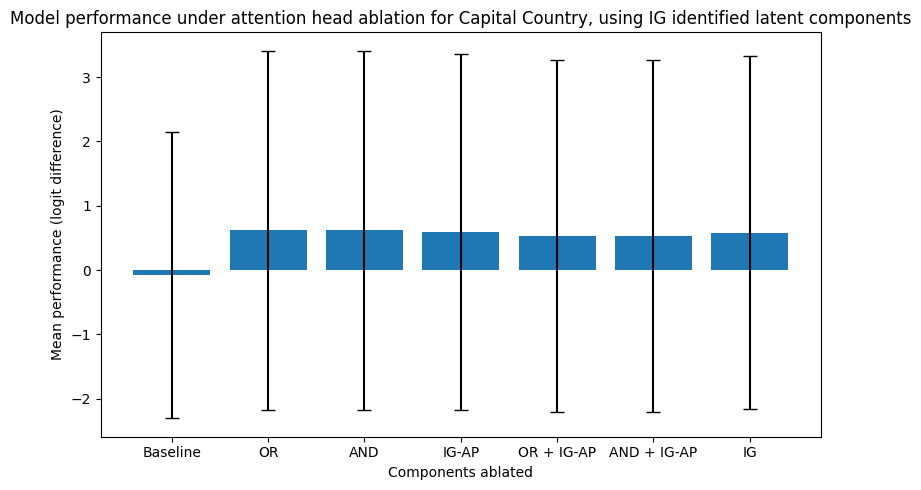

[-0.08078180253505707, 0.5563089847564697, 0.5563089847564697, 0.5935587882995605, 0.5396068096160889, 0.5396068096160889, 0.5723244547843933]


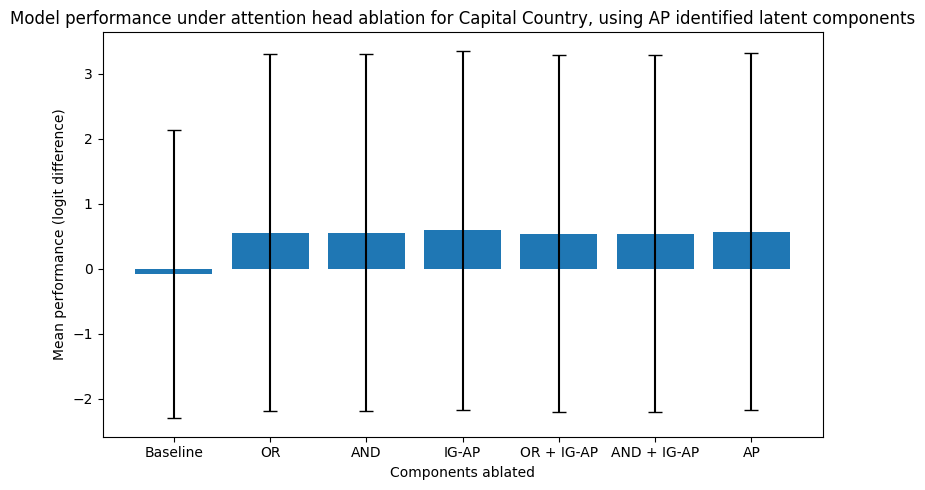

[-0.08078180253505707, 0.6501916646957397, 0.6501916646957397, 0.6409213542938232, 0.6409849524497986, 0.6409849524497986, 0.6431843638420105]


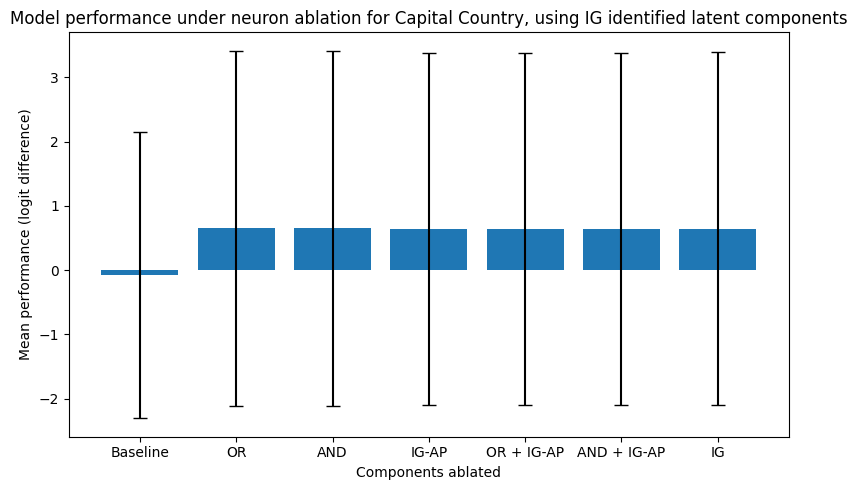

[-0.08078180253505707, 0.6631276607513428, 0.6631276607513428, 0.6409213542938232, 0.6409849524497986, 0.6409849524497986, 0.6433658003807068]


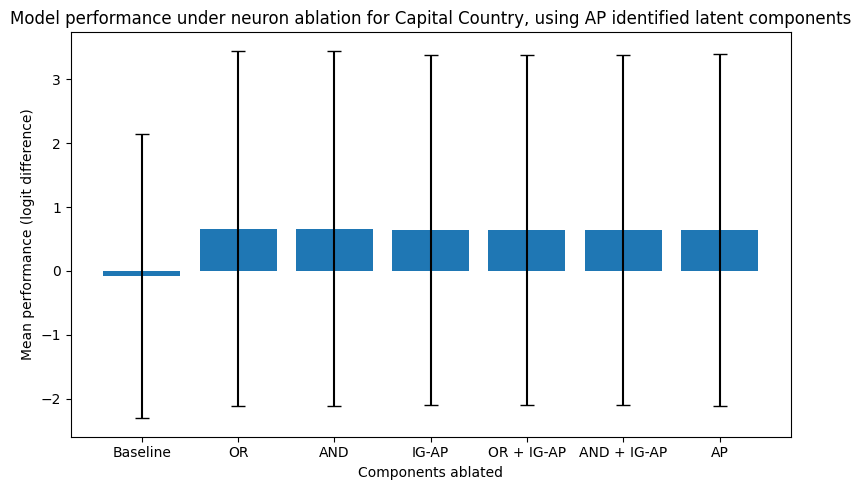

In [22]:
run_latent_ablation_experiment(model, capital_country_ig_clean_corrupt_mlp, capital_country_ig_clean_corrupt_attn, capital_country_ap_clean_corrupt_mlp, capital_country_ap_clean_corrupt_attn, capital_country_ig_corrupt_clean_mlp, capital_country_ig_corrupt_clean_attn, capital_country_ap_corrupt_clean_mlp, capital_country_ap_corrupt_clean_attn, Task.CAPITAL_COUNTRY)

latent_ig_attn_ablation_scores = torch.load("results/latent_components/capital_country/latent_ig_attn_ablation_scores.pt")
latent_ap_attn_ablation_scores = torch.load("results/latent_components/capital_country/latent_ap_attn_ablation_scores.pt")

latent_ig_mlp_ablation_scores = torch.load("results/latent_components/capital_country/latent_ig_mlp_ablation_scores.pt")
latent_ap_mlp_ablation_scores = torch.load("results/latent_components/capital_country/latent_ap_mlp_ablation_scores.pt")

plot_bar_chart(
    latent_ig_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Capital Country, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Capital Country, using AP identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ig_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Capital Country, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Capital Country, using AP identified latent components",
    has_std=True)

In [23]:
latent_ig_attn_ablation_scores, latent_ap_attn_ablation_scores, latent_ig_mlp_ablation_scores, latent_ap_mlp_ablation_scores

({'Baseline': (tensor(-0.0808), tensor(2.2236)),
  'OR': (tensor(0.6177), tensor(2.7935)),
  'AND': (tensor(0.6177), tensor(2.7935)),
  'IG-AP': (tensor(0.5936), tensor(2.7647)),
  'OR + IG-AP': (tensor(0.5291), tensor(2.7401)),
  'AND + IG-AP': (tensor(0.5291), tensor(2.7401)),
  'IG': (tensor(0.5823), tensor(2.7458))},
 {'Baseline': (tensor(-0.0808), tensor(2.2236)),
  'OR': (tensor(0.5563), tensor(2.7514)),
  'AND': (tensor(0.5563), tensor(2.7514)),
  'IG-AP': (tensor(0.5936), tensor(2.7647)),
  'OR + IG-AP': (tensor(0.5396), tensor(2.7455)),
  'AND + IG-AP': (tensor(0.5396), tensor(2.7455)),
  'AP': (tensor(0.5723), tensor(2.7481))},
 {'Baseline': (tensor(-0.0808), tensor(2.2236)),
  'OR': (tensor(0.6502), tensor(2.7614)),
  'AND': (tensor(0.6502), tensor(2.7614)),
  'IG-AP': (tensor(0.6409), tensor(2.7407)),
  'OR + IG-AP': (tensor(0.6410), tensor(2.7408)),
  'AND + IG-AP': (tensor(0.6410), tensor(2.7408)),
  'IG': (tensor(0.6432), tensor(2.7408))},
 {'Baseline': (tensor(-0.0808),

### Gender Bias

In [24]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.4348, -1.5338,  1.4572,  1.4659,  1.4542,  1.3636,  1.4376,  1.5102,
        -1.4453,  0.6453,  1.4408,  1.5409,  1.9085,  1.5206,  3.2713,  1.2645,
        -1.4762,  1.5827, -0.1731, -1.2693,  1.8740,  1.5169,  1.5449,  1.2635,
         1.5521, -1.4228, -1.5192, -1.4169, -1.3915, -1.4274,  1.8045,  3.1738,
        -1.4906,  1.5187, -1.5254,  1.4072,  1.4378, -1.3723,  1.4582,  1.5068,
        -1.5435, -1.4447,  2.2557, -1.4185,  1.4803,  1.3989, -1.4231,  1.5833,
         1.5432,  1.5064, -1.2827,  1.5562, -1.4473,  2.3805,  0.6395, -1.3350,
        -1.3978,  3.3996,  1.4925,  0.7471,  2.1428,  1.5288, -1.4112, -1.2596,
        -1.4297,  2.2779, -1.4844,  1.5051,  1.5515,  1.4641, -1.5070,  1.5229,
        -1.4662,  1.5414,  1.5559,  0.9713, -1.4052,  1.4867,  3.9474,  1.5111,
        -1.4275,  1.4870, -1.5117,  1.4568, -0.9252,  1.4716, -1.4398, -1.4266,
         2.5784, -1.3107, -1.3026,  1.4261,  1.4988, -1.3030,  1.5269,  1.5192,
        -1.4368,

In [103]:
gender_bias_ig_clean_corrupt_mlp, gender_bias_ig_clean_corrupt_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_clean_corrupt_mlp, "results/latent_components/gender_bias/ig_clean_corrupt_mlp.pt")
torch.save(gender_bias_ig_clean_corrupt_attn, "results/latent_components/gender_bias/ig_clean_corrupt_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 1.5885e-05, -1.3150e-06,  9.3691e-07, -6.8825e-07,  9.9838e-07,
        -9.6262e-06, -1.0999e-06,  3.4273e-07,  2.9057e-07,  2.8014e-06,
         2.1048e-07, -7.7114e-07,  6.2585e-06,  8.3912e-07,  3.5763e-07,
        -2.5630e-06, -9.5414e-07, -8.4937e-07, -2.1696e-05, -8.0466e-07,
         1.5318e-05,  1.5078e-06,  4.8429e-07,  7.8976e-06, -2.6301e-06,
        -1.3039e-07,  3.5018e-07, -2.5984e-07,  5.9605e-08,  3.6880e-07,
        -7.8678e-06,  1.0535e-05, -7.4133e-07,  2.2482e-06, -9.5926e-08,
        -7.6368e-07, -9.7789e-08, -5.7742e-08,  7.5251e-07, -1.2934e-05,
        -8.4098e-07, -7.4506e-08,  5.5432e-06, -1.2415e-06, -1.6391e-06,
        -5.8115e-07,  5.5321e-07, -2.6263e-07,  6.2212e-07,  5.8860e-07,
         5.0664e-07,  6.2771e-07,  1.0021e-06,  2.0862e-06, -9.7752e-06,
        -2.0536e-07,  8.7731e-07,  9.8944e-06, -1.5646e-07,  3.5763e-07,
        -9.8944e-06,  1.5516e-06, -1.0133e-06,  6.2212e-07, -1.415

In [ ]:
gender_bias_ap_clean_corrupt_mlp, gender_bias_ap_clean_corrupt_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_clean_corrupt_mlp, "results/latent_components/gender_bias/ap_clean_corrupt_mlp.pt")
torch.save(gender_bias_ap_clean_corrupt_attn, "results/latent_components/gender_bias/ap_clean_corrupt_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4


In [ ]:
gender_bias_ig_corrupt_clean_mlp, gender_bias_ig_corrupt_clean_attn = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_corrupt_clean_mlp, "results/latent_components/gender_bias/ig_corrupt_clean_mlp.pt")
torch.save(gender_bias_ig_corrupt_clean_attn, "results/latent_components/gender_bias/ig_corrupt_clean_attn.pt")

In [ ]:
gender_bias_ap_corrupt_clean_mlp, gender_bias_ap_corrupt_clean_attn = activation_patching(model, corrupted_tokens, corrupted_logit_diff, clean_cache, clean_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_corrupt_clean_mlp, "results/latent_components/gender_bias/ap_corrupt_clean_mlp.pt")
torch.save(gender_bias_ap_corrupt_clean_attn, "results/latent_components/gender_bias/ap_corrupt_clean_attn.pt")

In [25]:
gender_bias_ig_clean_corrupt_mlp = torch.load("results/latent_components/gender_bias/ig_clean_corrupt_mlp.pt")
gender_bias_ap_clean_corrupt_mlp = torch.load("results/latent_components/gender_bias/ap_clean_corrupt_mlp.pt")
gender_bias_ig_corrupt_clean_mlp = torch.load("results/latent_components/gender_bias/ig_corrupt_clean_mlp.pt")
gender_bias_ap_corrupt_clean_mlp = torch.load("results/latent_components/gender_bias/ap_corrupt_clean_mlp.pt")

gender_bias_ig_clean_corrupt_attn = torch.load("results/latent_components/gender_bias/ig_clean_corrupt_attn.pt")
gender_bias_ap_clean_corrupt_attn = torch.load("results/latent_components/gender_bias/ap_clean_corrupt_attn.pt")
gender_bias_ig_corrupt_clean_attn = torch.load("results/latent_components/gender_bias/ig_corrupt_clean_attn.pt")
gender_bias_ap_corrupt_clean_attn = torch.load("results/latent_components/gender_bias/ap_corrupt_clean_attn.pt")

In [13]:
print(f"Average absolute correlation between clean->corrupt IG and AP (MLP): {average_correlation(gender_bias_ig_clean_corrupt_mlp, gender_bias_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and AP (attention): {average_correlation(gender_bias_ig_clean_corrupt_attn, gender_bias_ap_clean_corrupt_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and AP (MLP): {average_correlation(gender_bias_ig_corrupt_clean_mlp, gender_bias_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and AP (attention): {average_correlation(gender_bias_ig_corrupt_clean_attn, gender_bias_ap_corrupt_clean_attn)}")

Average absolute correlation between clean->corrupt IG and AP (MLP): (np.float64(0.87334359287431), np.float64(0.3210200017530308))
Average absolute correlation between clean->corrupt IG and AP (attention): (np.float64(0.9394814623891503), np.float64(0.3410210043552813))
Average absolute correlation between corrupt->clean IG and AP (MLP): (np.float64(-0.8546711458772299), np.float64(0.3164839085360263))
Average absolute correlation between corrupt->clean IG and AP (attention): (np.float64(-0.9395970780066623), np.float64(0.3410158890261235))


In [14]:
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): {average_correlation(gender_bias_ig_clean_corrupt_mlp, gender_bias_ap_corrupt_clean_mlp)}")
print(f"Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): {average_correlation(gender_bias_ig_clean_corrupt_attn, gender_bias_ap_corrupt_clean_attn)}")

print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): {average_correlation(gender_bias_ig_corrupt_clean_mlp, gender_bias_ap_clean_corrupt_mlp)}")
print(f"Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): {average_correlation(gender_bias_ig_corrupt_clean_attn, gender_bias_ap_clean_corrupt_attn)}")

Average absolute correlation between clean->corrupt IG and corrupt->clean AP (MLP): (np.float64(0.5081068376024426), np.float64(0.24639382682364516))
Average absolute correlation between clean->corrupt IG and corrupt->clean AP (attention): (np.float64(0.9050914503686721), np.float64(0.332447259166971))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (MLP): (np.float64(-0.4957326170384933), np.float64(0.25790056297170644))
Average absolute correlation between corrupt->clean IG and clean->corrupt AP (attention): (np.float64(-0.905154634774228), np.float64(0.33254879300524853))


In [28]:
gender_bias_ig_mlp_asymmetry = asymmetry_score(gender_bias_ig_clean_corrupt_mlp, gender_bias_ig_clean_corrupt_mlp, is_ig=True)
gender_bias_ig_attn_asymmetry = asymmetry_score(gender_bias_ig_corrupt_clean_attn, gender_bias_ig_clean_corrupt_attn, is_ig=True)

gender_bias_ap_mlp_asymmetry = asymmetry_score(gender_bias_ap_corrupt_clean_mlp, gender_bias_ap_clean_corrupt_mlp, is_ig=False)
gender_bias_ap_attn_asymmetry = asymmetry_score(gender_bias_ap_corrupt_clean_attn, gender_bias_ap_clean_corrupt_attn, is_ig=False)

print(f"Average correlation between AP and IG asymmetry for attention heads: {average_correlation(gender_bias_ap_attn_asymmetry, gender_bias_ig_attn_asymmetry)}")
print(f"Average correlation between AP and IG asymmetry for MLP neurons: {average_correlation(gender_bias_ap_mlp_asymmetry, gender_bias_ig_mlp_asymmetry)}")

gender_bias_mlp_disagreement = asymmetry_score(gender_bias_ig_corrupt_clean_mlp, gender_bias_ap_corrupt_clean_mlp, is_ig=False)
gender_bias_attn_disagreement = asymmetry_score(gender_bias_ig_corrupt_clean_attn, gender_bias_ap_corrupt_clean_attn, is_ig=False)
print(f"Correlation between disagreement and asymmetry for attention heads: {average_correlation(gender_bias_attn_disagreement, gender_bias_ap_attn_asymmetry)}")
print(f"Correlation between disagreement and asymmetry for MLP: {average_correlation(gender_bias_mlp_disagreement, gender_bias_ap_mlp_asymmetry)}")

gender_bias_exclusive_mlp = highlight_components(gender_bias_mlp_disagreement)[0]
gender_bias_exclusive_attn = highlight_components(gender_bias_attn_disagreement)[0]
gender_bias_latent_mlp = highlight_components(gender_bias_ap_mlp_asymmetry)[0]
gender_bias_latent_attn = highlight_components(gender_bias_ap_attn_asymmetry)[0]
print(f"Average overlap between exclusive components and latent neurons: {measure_overlap(gender_bias_exclusive_mlp, gender_bias_latent_mlp).mean()}, {measure_overlap(gender_bias_exclusive_mlp, gender_bias_latent_mlp).std()}")
print(f"Average overlap between exclusive components and latent attention heads: {measure_overlap(gender_bias_exclusive_attn, gender_bias_latent_attn).mean()}, {measure_overlap(gender_bias_exclusive_attn, gender_bias_latent_attn).std()}")

Average correlation between AP and IG asymmetry for attention heads: (np.float64(-0.9270223725604173), np.float64(0.3343704342719868))
Average correlation between AP and IG asymmetry for MLP neurons: (np.float64(-0.38462550500245996), np.float64(0.2333717354975664))
Correlation between disagreement and asymmetry for attention heads: (np.float64(0.05173020693495924), np.float64(0.3463514418988173))
Correlation between disagreement and asymmetry for MLP: (np.float64(-0.44357999440121093), np.float64(0.3190019534703389))
Average overlap between exclusive components and latent neurons: 0.2921585738658905, 0.12505654990673065
Average overlap between exclusive components and latent attention heads: 0.2186906933784485, 0.08459073305130005


Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.003844168270006776, Std performance difference: 2.370927333831787
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.09834197908639908, Std performance difference: 2.2473459243774414
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.08819511532783508, Std performance difference: 2.4489591121673584
Test IOI performance with 100 samples of ablated components
Mean performance difference: 0.08160896599292755, Std performance difference: 2.4518837928771973
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.003844168270006776, Std performance difference: 2.370927333831787
Test IOI performance with 100 samples of ablated components
Mean performance difference: -0.09834197908639908, Std performance difference: 2.2473459243774414
Test IOI performance with 100 samples of ablated compo

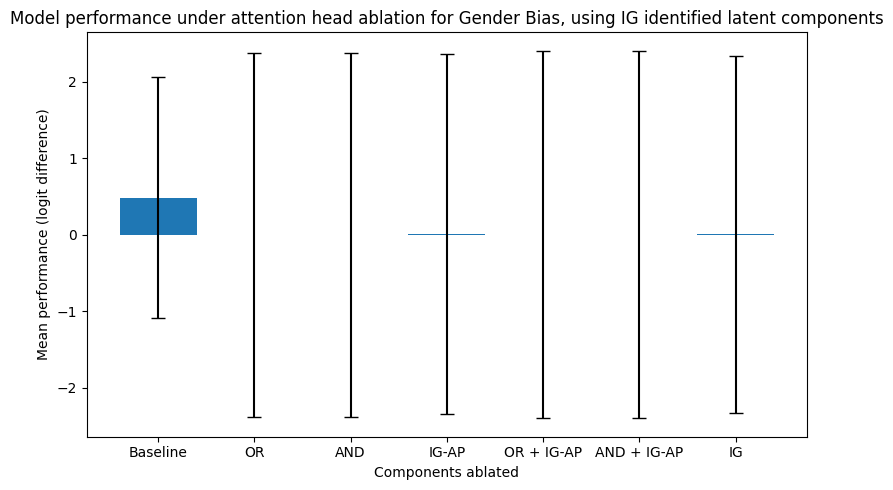

[0.4862512946128845, -0.09834197908639908, -0.09834197908639908, 0.0061583686619997025, -0.02582884579896927, -0.02582884579896927, 0.0015715383924543858]


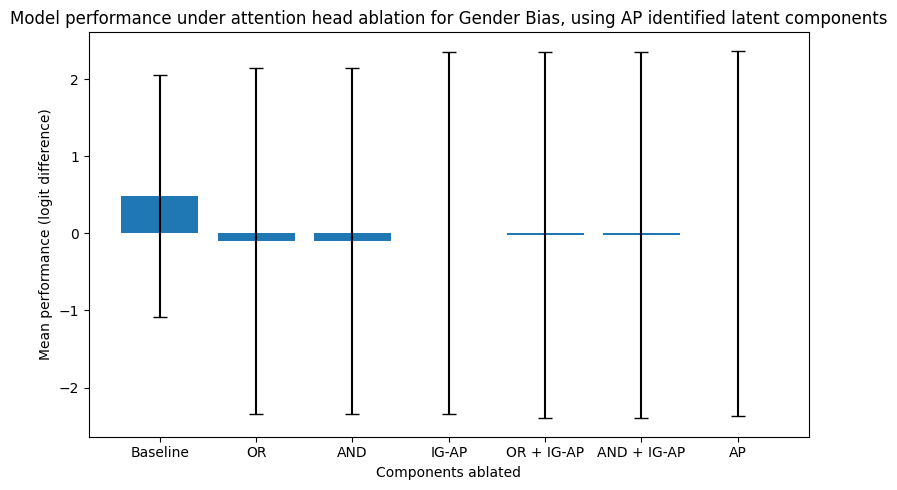

[0.4862512946128845, 0.08819511532783508, 0.08819511532783508, 0.08277732133865356, 0.08277732133865356, 0.08277732133865356, 0.08318430930376053]


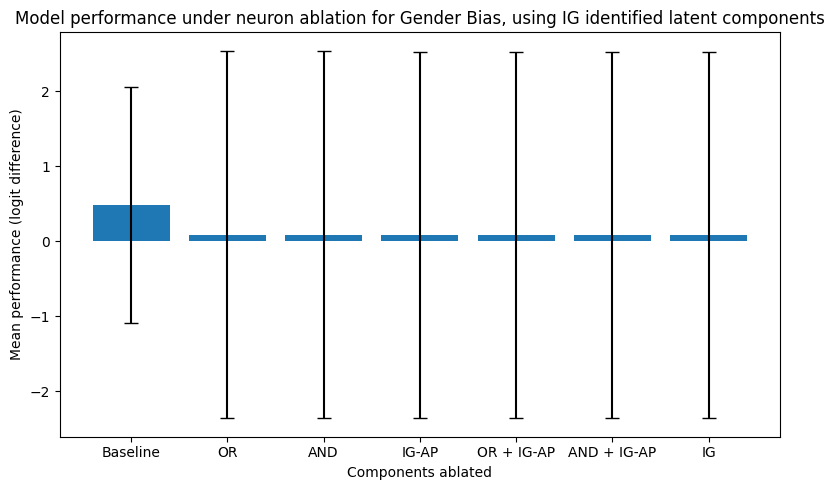

[0.4862512946128845, 0.08160896599292755, 0.08160896599292755, 0.08277732133865356, 0.08277732133865356, 0.08277732133865356, 0.0964336171746254]


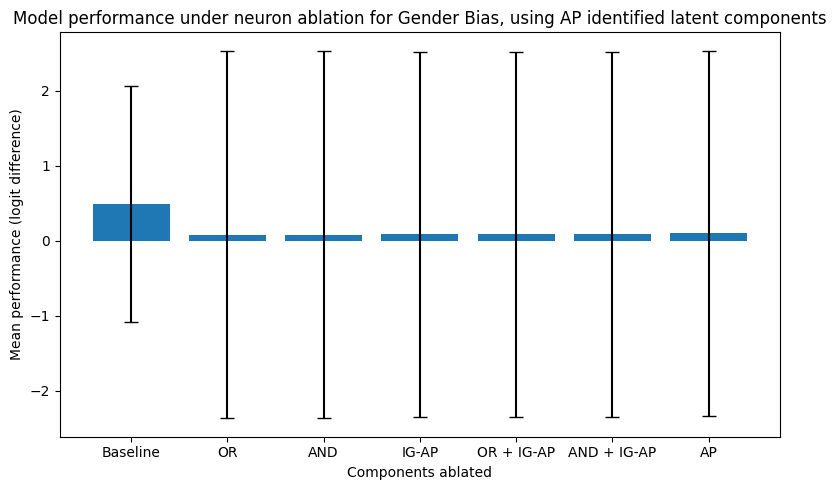

In [26]:
run_latent_ablation_experiment(model, gender_bias_ig_clean_corrupt_mlp, gender_bias_ig_clean_corrupt_attn, gender_bias_ap_clean_corrupt_mlp, gender_bias_ap_clean_corrupt_attn, gender_bias_ig_corrupt_clean_mlp, gender_bias_ig_corrupt_clean_attn, gender_bias_ap_corrupt_clean_mlp, gender_bias_ap_corrupt_clean_attn, Task.GENDER_BIAS)

latent_ig_attn_ablation_scores = torch.load("results/latent_components/gender_bias/latent_ig_attn_ablation_scores.pt")
latent_ap_attn_ablation_scores = torch.load("results/latent_components/gender_bias/latent_ap_attn_ablation_scores.pt")

latent_ig_mlp_ablation_scores = torch.load("results/latent_components/gender_bias/latent_ig_mlp_ablation_scores.pt")
latent_ap_mlp_ablation_scores = torch.load("results/latent_components/gender_bias/latent_ap_mlp_ablation_scores.pt")

plot_bar_chart(
    latent_ig_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Gender Bias, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_attn_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under attention head ablation for Gender Bias, using AP identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ig_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Gender Bias, using IG identified latent components",
    has_std=True)

plot_bar_chart(
    latent_ap_mlp_ablation_scores, 
    "Components ablated", 
    "Mean performance (logit difference)", 
    "Model performance under neuron ablation for Gender Bias, using AP identified latent components",
    has_std=True)

In [27]:
latent_ig_attn_ablation_scores, latent_ap_attn_ablation_scores, latent_ig_mlp_ablation_scores, latent_ap_mlp_ablation_scores

({'Baseline': (tensor(0.4863), tensor(1.5729)),
  'OR': (tensor(-0.0038), tensor(2.3709)),
  'AND': (tensor(-0.0038), tensor(2.3709)),
  'IG-AP': (tensor(0.0062), tensor(2.3487)),
  'OR + IG-AP': (tensor(0.0030), tensor(2.4003)),
  'AND + IG-AP': (tensor(0.0030), tensor(2.4003)),
  'IG': (tensor(0.0044), tensor(2.3332))},
 {'Baseline': (tensor(0.4863), tensor(1.5729)),
  'OR': (tensor(-0.0983), tensor(2.2473)),
  'AND': (tensor(-0.0983), tensor(2.2473)),
  'IG-AP': (tensor(0.0062), tensor(2.3487)),
  'OR + IG-AP': (tensor(-0.0258), tensor(2.3725)),
  'AND + IG-AP': (tensor(-0.0258), tensor(2.3725)),
  'AP': (tensor(0.0016), tensor(2.3666))},
 {'Baseline': (tensor(0.4863), tensor(1.5729)),
  'OR': (tensor(0.0882), tensor(2.4490)),
  'AND': (tensor(0.0882), tensor(2.4490)),
  'IG-AP': (tensor(0.0828), tensor(2.4375)),
  'OR + IG-AP': (tensor(0.0828), tensor(2.4375)),
  'AND + IG-AP': (tensor(0.0828), tensor(2.4375)),
  'IG': (tensor(0.0832), tensor(2.4376))},
 {'Baseline': (tensor(0.4863

## Amplification Experiments

We amplify identified latent neurons by doubling their activations. 

For each relation, we plot the average change ratio of the probability for the correct answer, corresponding to the manipulation.

As baselines, we amplify random neurons, and we amplify commonly highlighted neurons.

### Experiments

In [ ]:
from testing import test_single_amplified_performance

# Baseline performance: commonly highlighted attention heads
both_attn_amplified_performance = dict()
for sample, layer, idx in both_attn_indices:
    if sample == 0:
        performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=True)
        both_attn_amplified_performance[(layer, idx)] = performance

torch.save(both_attn_amplified_performance, "results/latent_components/amplified/both_attn_amplified_performance.pt")

In [33]:
# Baseline performance: commonly highlighted MLP neurons
both_mlp_amplified_performance = dict()
n = 0
for sample, layer, idx in both_mlp_indices:
    if n > 100:
        break
    if sample == 0:
        performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=False)
        both_mlp_amplified_performance[(layer, idx)] = performance
        n += 1

torch.save(both_mlp_amplified_performance, "results/latent_components/amplified/both_mlp_amplified_performance.pt")

Test IOI performance with ablated (7, 2439)
Mean performance: 0.6624521017074585
Test IOI performance with ablated (6, 1059)
Mean performance: 0.6618839502334595
Test IOI performance with ablated (2, 485)
Mean performance: 0.6580320000648499
Test IOI performance with ablated (8, 1723)
Mean performance: 0.6609739661216736
Test IOI performance with ablated (0, 276)
Mean performance: 0.6594911813735962
Test IOI performance with ablated (6, 2108)
Mean performance: 0.6605031490325928
Test IOI performance with ablated (10, 2981)
Mean performance: 0.6620892286300659
Test IOI performance with ablated (9, 2192)
Mean performance: 0.6610257625579834
Test IOI performance with ablated (1, 1146)
Mean performance: 0.6612012386322021
Test IOI performance with ablated (3, 818)
Mean performance: 0.6550179719924927
Test IOI performance with ablated (5, 1482)
Mean performance: 0.6590794920921326
Test IOI performance with ablated (8, 975)
Mean performance: 0.6601926684379578
Test IOI performance with ablat

In [15]:
from testing import test_single_amplified_performance

# Amplify latent attention heads
latent_attn_amplification_score = dict()
for layer, idx in latent_attn_ig[0].nonzero():
    performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=True)
    latent_attn_amplification_score[(layer, idx)] = performance

torch.save(latent_attn_amplification_score, "results/latent_components/amplified/latent_attn_amplification_score.pt")

Test IOI performance with ablated (tensor(0), tensor(1))
Mean performance: 0.6832503080368042
Test IOI performance with ablated (tensor(0), tensor(4))
Mean performance: 0.6510929465293884
Test IOI performance with ablated (tensor(0), tensor(8))
Mean performance: 0.6451183557510376
Test IOI performance with ablated (tensor(0), tensor(11))
Mean performance: 0.6409765481948853
Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: 0.7087669968605042
Test IOI performance with ablated (tensor(5), tensor(5))
Mean performance: 0.6729890704154968
Test IOI performance with ablated (tensor(6), tensor(6))
Mean performance: 0.6264835596084595
Test IOI performance with ablated (tensor(6), tensor(9))
Mean performance: 0.7075578570365906


In [26]:
# Amplify latent MLP neurons
latent_mlp_amplification_score = dict()
for layer, idx in latent_mlp_ig[0].nonzero():
    performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=False)
    latent_mlp_amplification_score[(layer, idx)] = performance

torch.save(latent_mlp_amplification_score, "results/latent_components/amplified/latent_mlp_amplification_score.pt")

Test IOI performance with ablated (tensor(1), tensor(79))
Mean performance: 0.6472392678260803
Test IOI performance with ablated (tensor(1), tensor(508))
Mean performance: 0.6598694920539856
Test IOI performance with ablated (tensor(1), tensor(824))
Mean performance: 0.5963168740272522
Test IOI performance with ablated (tensor(2), tensor(620))
Mean performance: 0.6538259387016296
Test IOI performance with ablated (tensor(2), tensor(1987))
Mean performance: 0.6621095538139343
Test IOI performance with ablated (tensor(2), tensor(2295))
Mean performance: 0.652522623538971
Test IOI performance with ablated (tensor(3), tensor(74))
Mean performance: 0.6606041193008423
Test IOI performance with ablated (tensor(3), tensor(1026))
Mean performance: 0.6535995602607727
Test IOI performance with ablated (tensor(3), tensor(1545))
Mean performance: 0.6567400097846985
Test IOI performance with ablated (tensor(3), tensor(2561))
Mean performance: 0.6577517986297607
Test IOI performance with ablated (ten

In [16]:
# Baseline performance: random attention heads with low attribution scores
non_highlighted_attn = ~latent_attn_ig & ~ig_attn_significant & ~ap_attn_significant
non_highlighted_attn_amplified_performance = dict()
for layer, idx in non_highlighted_attn[0].nonzero():
    performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=True)
    non_highlighted_attn_amplified_performance[(layer, idx)] = performance

torch.save(non_highlighted_attn_amplified_performance, "results/latent_components/amplified/non_highlighted_attn_amplified_performance.pt")

Test IOI performance with ablated (tensor(0), tensor(0))
Mean performance: 0.6740821003913879
Test IOI performance with ablated (tensor(0), tensor(2))
Mean performance: 0.647725522518158
Test IOI performance with ablated (tensor(0), tensor(3))
Mean performance: 0.7743440270423889
Test IOI performance with ablated (tensor(0), tensor(5))
Mean performance: 0.7073206901550293
Test IOI performance with ablated (tensor(0), tensor(7))
Mean performance: 0.6313045620918274
Test IOI performance with ablated (tensor(0), tensor(9))
Mean performance: 0.5149269700050354
Test IOI performance with ablated (tensor(0), tensor(10))
Mean performance: 0.6606304049491882
Test IOI performance with ablated (tensor(1), tensor(0))
Mean performance: 0.6489903926849365
Test IOI performance with ablated (tensor(1), tensor(1))
Mean performance: 0.676677405834198
Test IOI performance with ablated (tensor(1), tensor(2))
Mean performance: 0.6432405114173889
Test IOI performance with ablated (tensor(1), tensor(3))
Mean

In [ ]:
# Baseline performance: random neurons with low attribution scores
non_highlighted_mlp = ~latent_mlp_ig & ~ig_mlp_significant & ~ap_mlp_significant
non_highlighted_mlp_amplified_performance = dict()
# Randomly sample non-highlighted neurons
non_highlighted_mlp_indices = non_highlighted_mlp[0].nonzero()
perm = torch.randperm(non_highlighted_mlp_indices.size(0))
random_indices = perm[:100]  # Sample 100 random indices
for layer, idx in non_highlighted_mlp_indices[random_indices]:
    performance = test_single_amplified_performance(model, layer, idx, Task.IOI, is_attn=False)
    non_highlighted_mlp_amplified_performance[(layer, idx)] = performance

torch.save(non_highlighted_mlp_amplified_performance, "results/latent_components/amplified/non_highlighted_mlp_amplified_performance.pt")

Test IOI performance with ablated (tensor(0), tensor(1))
Mean performance: 0.6610025763511658
Test IOI performance with ablated (tensor(0), tensor(2))
Mean performance: 0.6610434651374817
Test IOI performance with ablated (tensor(0), tensor(4))
Mean performance: 0.6606823801994324
Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.6608856320381165
Test IOI performance with ablated (tensor(0), tensor(7))
Mean performance: 0.6603047847747803
Test IOI performance with ablated (tensor(0), tensor(8))
Mean performance: 0.6601433753967285
Test IOI performance with ablated (tensor(0), tensor(9))
Mean performance: 0.6597543358802795
Test IOI performance with ablated (tensor(0), tensor(10))
Mean performance: 0.6641367077827454
Test IOI performance with ablated (tensor(0), tensor(11))
Mean performance: 0.6634690761566162
Test IOI performance with ablated (tensor(0), tensor(12))
Mean performance: 0.6596871614456177
Test IOI performance with ablated (tensor(0), tensor(13))

KeyboardInterrupt: 

### Analysis

In [34]:
# Load saved results
both_attn_amplified_performance = torch.load("results/latent_components/amplified/both_attn_amplified_performance.pt")
both_mlp_amplified_performance = torch.load("results/latent_components/amplified/both_mlp_amplified_performance.pt")
latent_attn_amplification_score = torch.load("results/latent_components/amplified/latent_attn_amplification_score.pt")
latent_mlp_amplification_score = torch.load("results/latent_components/amplified/latent_mlp_amplification_score.pt")
non_highlighted_attn_amplified_performance = torch.load("results/latent_components/amplified/non_highlighted_attn_amplified_performance.pt")
non_highlighted_mlp_amplified_performance = torch.load("results/latent_components/amplified/non_highlighted_mlp_amplified_performance.pt")

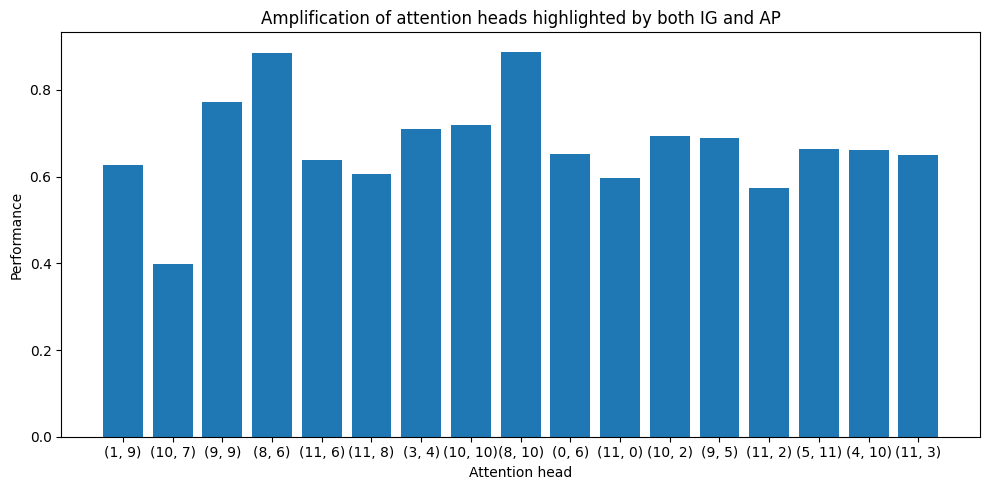

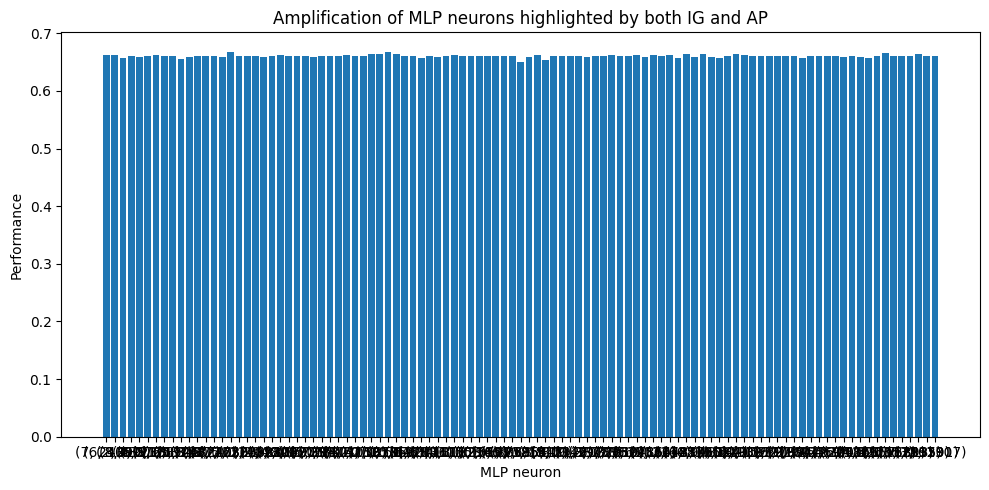

In [35]:
plot_bar_chart(both_attn_amplified_performance, "Attention head", "Performance", "Amplification of attention heads highlighted by both IG and AP")
plot_bar_chart(both_mlp_amplified_performance, "MLP neuron", "Performance", "Amplification of MLP neurons highlighted by both IG and AP")

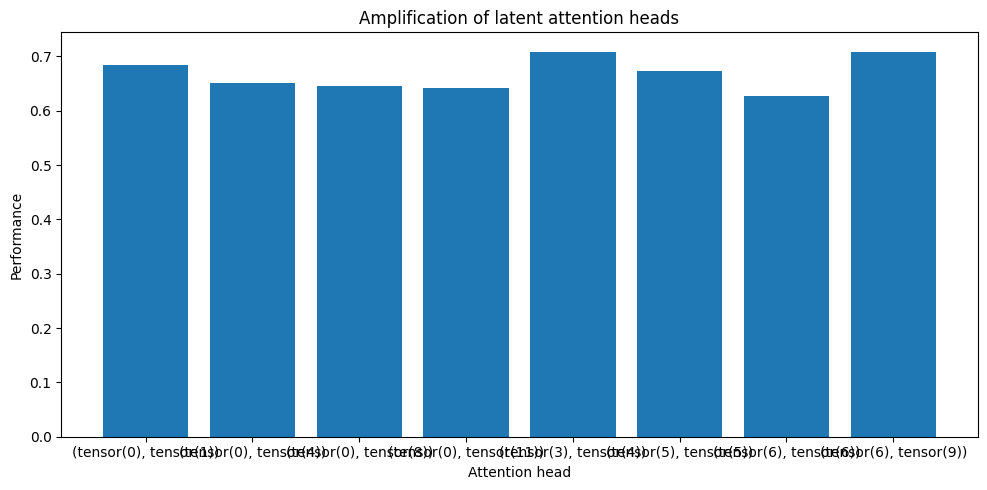

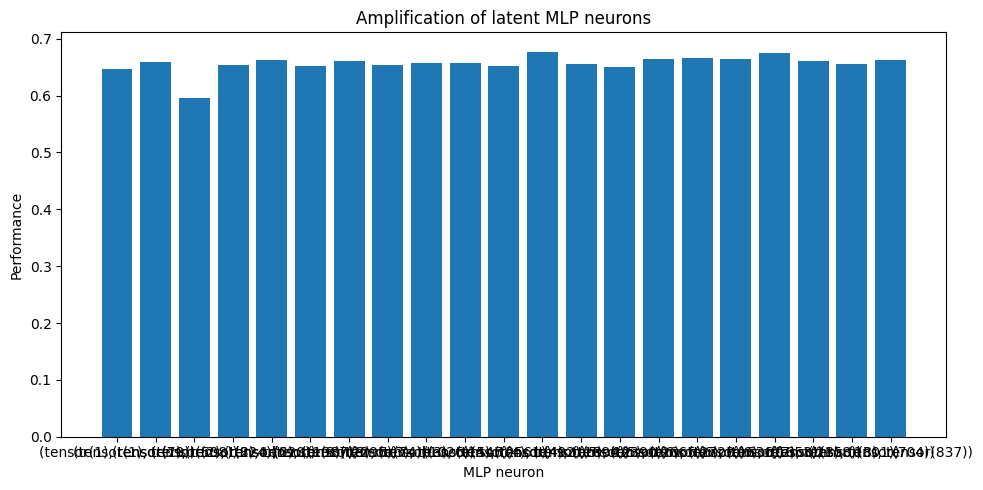

In [36]:
plot_bar_chart(
    latent_attn_amplification_score, 
    "Attention head", 
    "Performance", 
    "Amplification of latent attention heads"
)

plot_bar_chart(
    latent_mlp_amplification_score, 
    "MLP neuron", 
    "Performance", 
    "Amplification of latent MLP neurons"
)

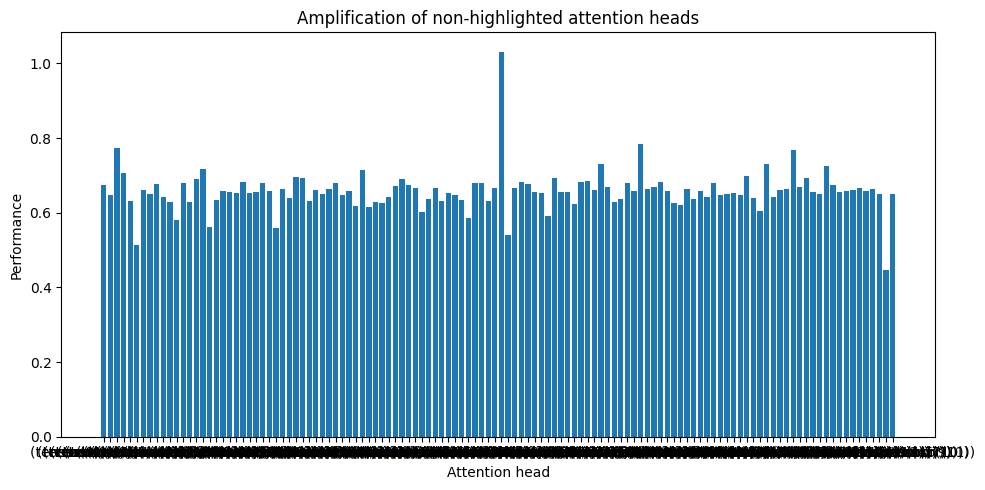

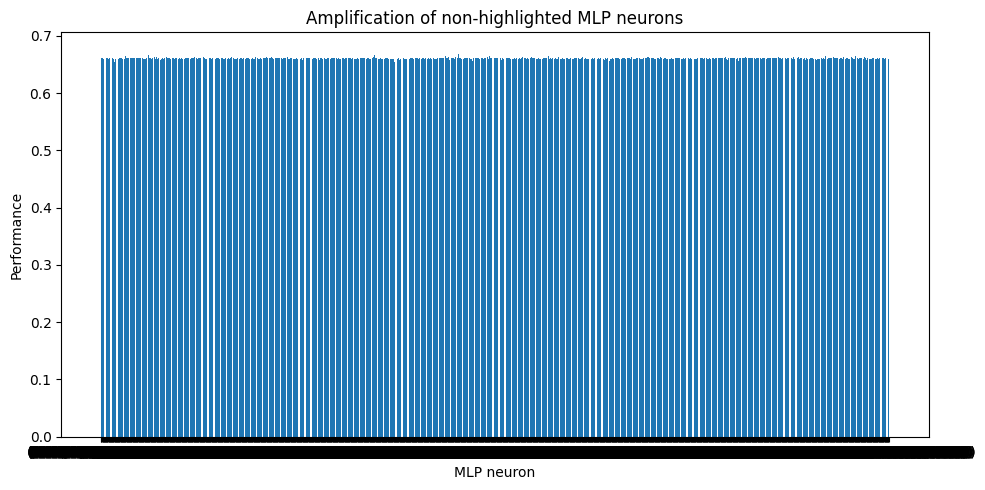

In [37]:
plot_bar_chart(non_highlighted_attn_amplified_performance, "Attention head", "Performance", "Amplification of non-highlighted attention heads")
plot_bar_chart(non_highlighted_mlp_amplified_performance, "MLP neuron", "Performance", "Amplification of non-highlighted MLP neurons")

In [39]:
amplification_attn_scores = {
    "Both IG and AP": torch.tensor(list(both_attn_amplified_performance.values())).mean(),
    "Latent": torch.tensor(list(latent_attn_amplification_score.values())).mean(),
    "Non-highlighted": torch.tensor(list(non_highlighted_attn_amplified_performance.values())).mean()
}

amplification_mlp_scores = {
    "Both IG and AP": torch.tensor(list(both_mlp_amplified_performance.values())).mean(),
    "Latent": torch.tensor(list(latent_mlp_amplification_score.values())).mean(),
    "Non-highlighted": torch.tensor(list(non_highlighted_mlp_amplified_performance.values())).mean()
}

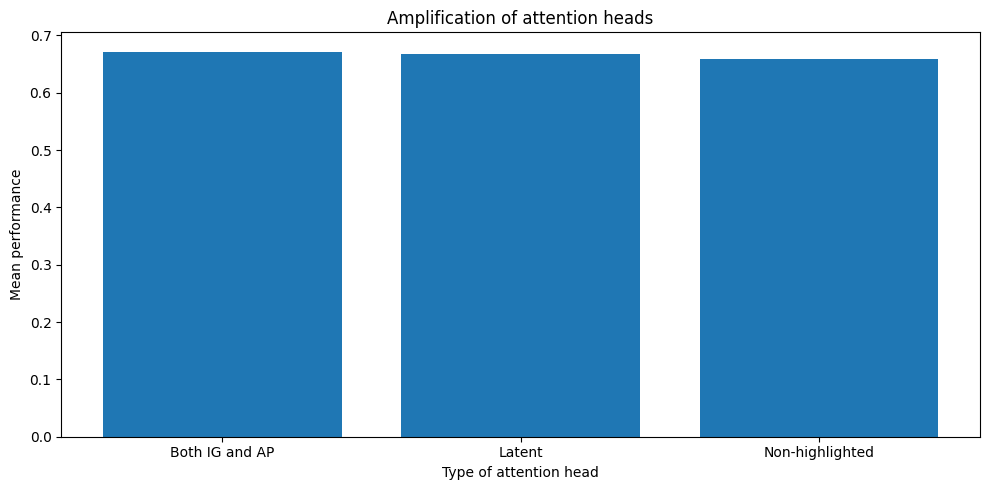

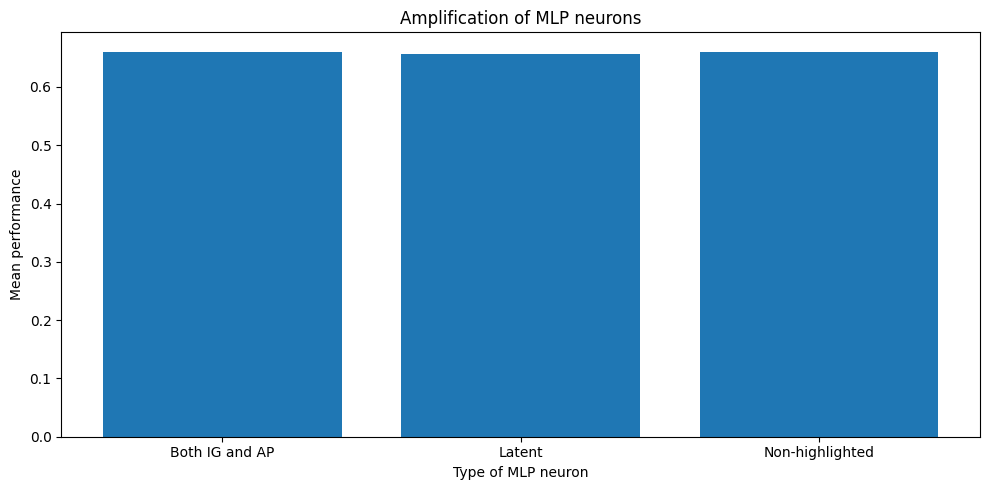

In [40]:
plot_bar_chart(amplification_attn_scores, "Type of attention head", "Mean performance", "Amplification of attention heads")
plot_bar_chart(amplification_mlp_scores, "Type of MLP neuron", "Mean performance", "Amplification of MLP neurons")